In [86]:
print("hello world")

hello world


In [87]:
import datetime as dt

import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose

from functions import (bucketize_column, plot_the_loss_curve, create_model,
                       train_model, replace_with_linear_interpolation,
                       plot_the_loss_curves, tf_error, evaluate_model, predict_model,
                       np_error)

plt.rcParams.update({'figure.figsize': (7,7)})

In [88]:
def my_decompose(values, period, model='additive'):
    'multiplicative'
    result = seasonal_decompose(
        values, model=model, extrapolate_trend='freq', period=eval(period))

    # result.plot().suptitle(f'{model} Decompose {period}', fontsize=22)

    return result


def plot_seasonal(seasonal, period):
    fig, axs = plt.subplots(1, 2, figsize=(16,7))
    sections = np.split(seasonal, range(period, len(seasonal) - len(seasonal)%period, period))
    if len(sections[-1]) != period:
        del sections[-1]
    mean = np.mean(sections, axis=0)

    for section in sections:
        axs[0].plot(section)

    print(mean - seasonal[:period])

    axs[1].plot(seasonal)
    plt.show()


def apply(period, values):
    decomposed = my_decompose(values, period)
    decomposed.plot().suptitle(f'additive Decompose {period}', fontsize=22)
    plt.show()

    plot_seasonal(np.array(decomposed.trend), eval(period))
    plot_seasonal(np.array(decomposed.seasonal), eval(period))
    plot_seasonal(np.array(decomposed.resid), eval(period))

    values = values - decomposed.trend
    values = values - decomposed.seasonal

    return values, decomposed

In [89]:
train = pd.read_csv("train.csv")
train

,datetime,total
0,01.01.2005 00:00:00,?
1,01.01.2005 01:00:00,154140
2,01.01.2005 02:00:00,157818
3,01.01.2005 03:00:00,149311
4,01.01.2005 04:00:00,138282
...,...,...
35059,31.12.2008 19:00:00,249376
35060,31.12.2008 20:00:00,246511
35061,31.12.2008 21:00:00,226469
35062,31.12.2008 22:00:00,199907


In [90]:
train['total'].replace("?", -1000, inplace=True)
train['total'] = train['total'].astype(np.int32)

train[train['total'] <= 0]

,datetime,total
0,01.01.2005 00:00:00,-1000
3936,14.06.2005 00:00:00,-1000
3944,14.06.2005 08:00:00,-1000
3970,15.06.2005 10:00:00,-1000
3973,15.06.2005 13:00:00,-1000
...,...,...
34329,01.12.2008 09:00:00,-1000
34464,07.12.2008 00:00:00,-1000
34475,07.12.2008 11:00:00,-1000
34477,07.12.2008 13:00:00,-1000


In [91]:
time_format = "%d.%m.%Y %H:%M:%S"
train["datetime"] = [dt.datetime.strptime(s, time_format) for s in train["datetime"]]
train.sort_values(by=["datetime"], inplace=True)

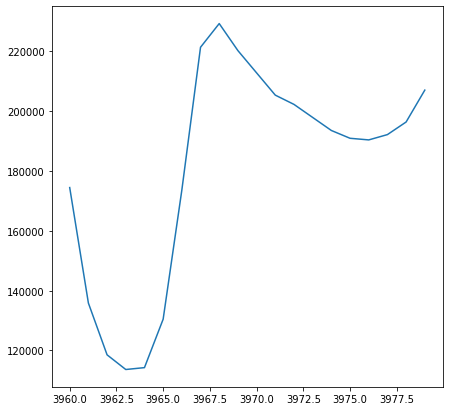

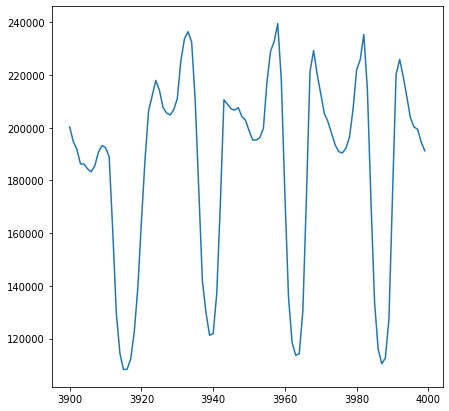

In [92]:
# replace non-positive values with linear interpolation
replace_with_linear_interpolation(train, train['total'] <= 0)

plt.plot(train[3960:3980]["total"])
plt.show()
plt.plot(train[3900:4000]["total"])
plt.show()

In [93]:
original_total = train["total"].copy()

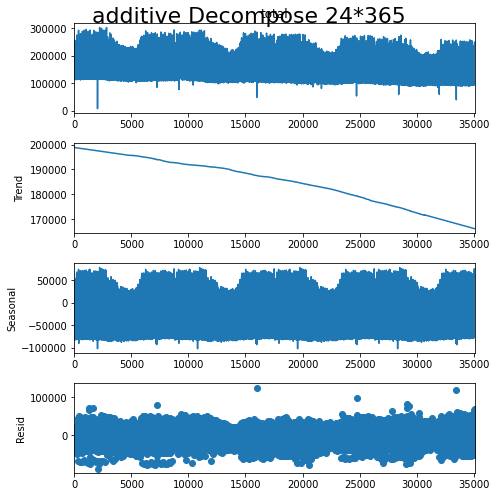

[-6162.45786499 -6162.87260542 -6163.15738011 ... -7285.7814688
 -7284.82929033 -7284.50351979]


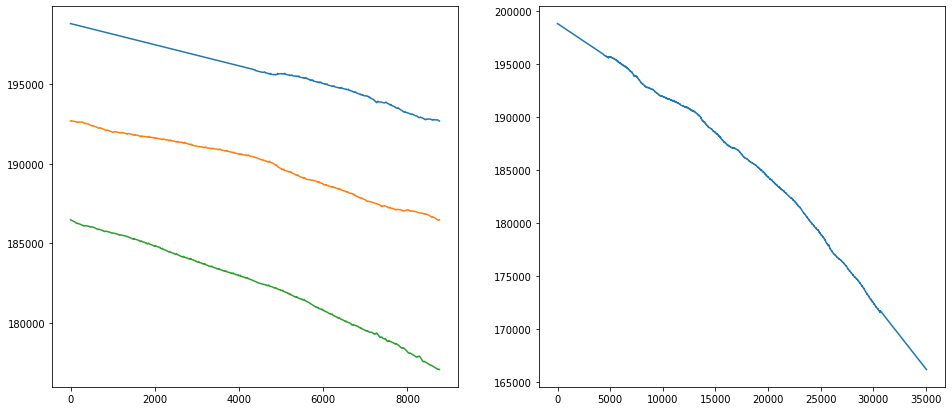

[0. 0. 0. ... 0. 0. 0.]


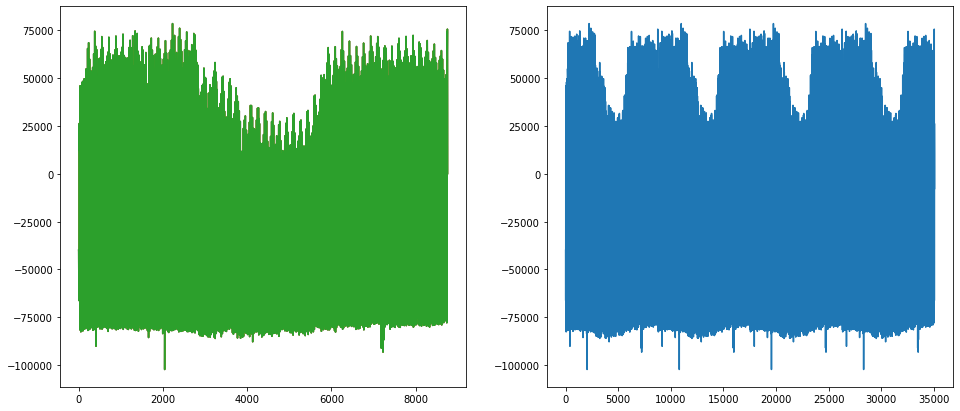

[-3571.20880168  1121.53927209  -731.17595322 ... -4310.88519787
 -1053.17070967  1065.17018645]


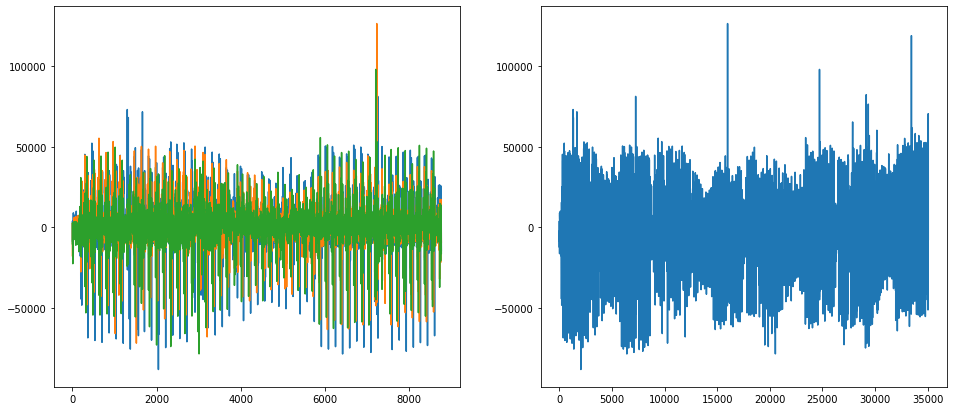

In [94]:
_, year_decomposed = apply("24*365", train["total"])

In [95]:
global_trend = year_decomposed.trend
train['total'] -= global_trend

In [96]:
global_trend_shift = np.mean(global_trend)
global_trend -= global_trend_shift

In [97]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c


def func(x, a, b, c, e, f):
    return a * np.exp(-b * x) + c + e * (x + f)**2


# def func(x, a, b, c, d, e):
#     return a + b*x + c*x**2 + d*x**3 + e*x**4  # a*np.exp(-b*x) +


# def func(x, a, b, c, e, f, g, h):
#     return a * np.exp(-b * x) + c + e * f**2 + g * h**3


# def func(x, a, b, offset):
#     return 1.0 / (1.0 + np.exp(-a * (x-b))) + offset

# method : {'lm', 'trf', 'dogbox'}
popt, pcov = curve_fit(func, global_trend.index, global_trend)#, method='dogbox')
print(popt)
# [ 6.80965581e+02  5.54983660e+05  2.01353392e+05 -1.40515861e-05 1.50944272e+04]

[ 6.80965593e+02  6.90529146e+05  1.63968907e+04 -1.40515862e-05
  1.50944271e+04]


C:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexes\base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
C:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


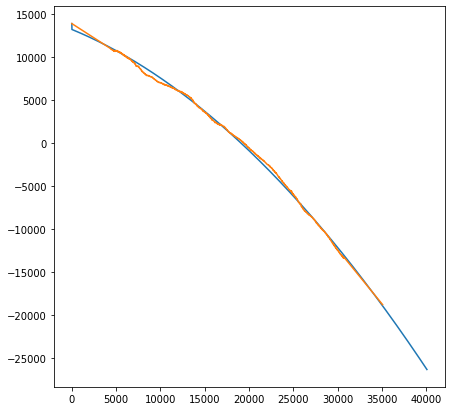

In [98]:
_x_data = np.arange(len(global_trend) + 5000)
plt.plot(_x_data, func(_x_data, *popt),
         label=f'fit: {popt}')#a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(global_trend, label="data")
plt.show()

In [99]:
with open("a.txt", "w", encoding="utf-8") as f:
    f.write(", ".join(list(map(str, zip(global_trend.index, global_trend)))))

In [100]:
# replace outlier values with linear interpolation
print(len(train[train['total'] < -100_000]) / len(train))

replace_with_linear_interpolation(train, train['total'] < -100_000)

0.0002851927903262606


In [101]:
train['total'].describe()

count     35064.000000
mean        182.310707
std       44510.593192
min      -98843.734361
25%      -27666.754693
50%       11630.643215
75%       32287.640240
max      105232.374088
Name: total, dtype: float64

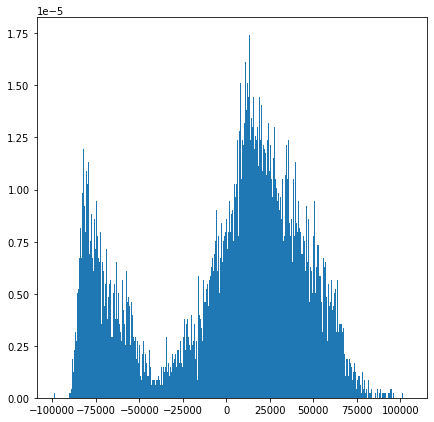

In [102]:
plt.hist(train["total"], 1500, density=True)
plt.show()

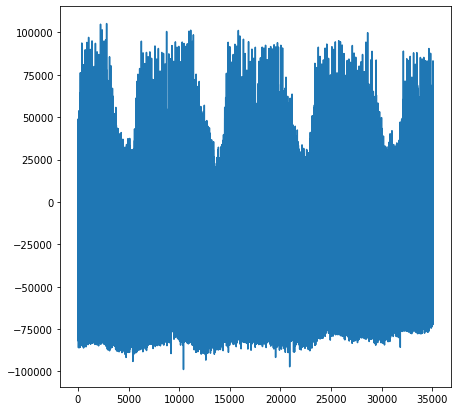

In [103]:
plt.plot(train["total"])

24*365


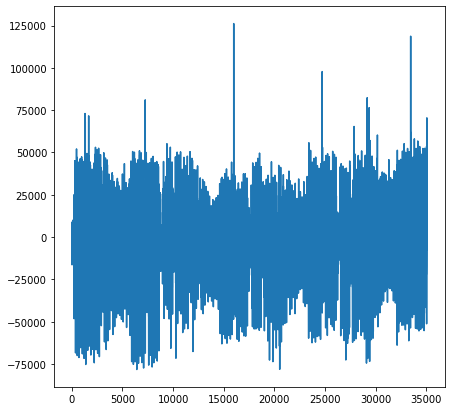

12


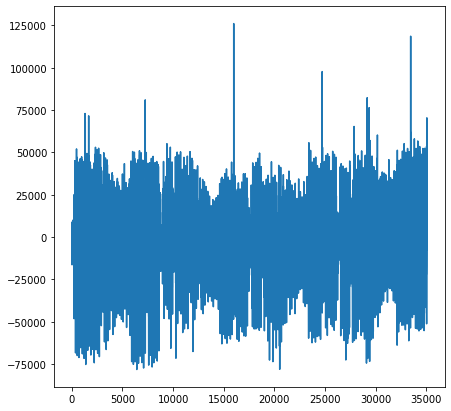

24


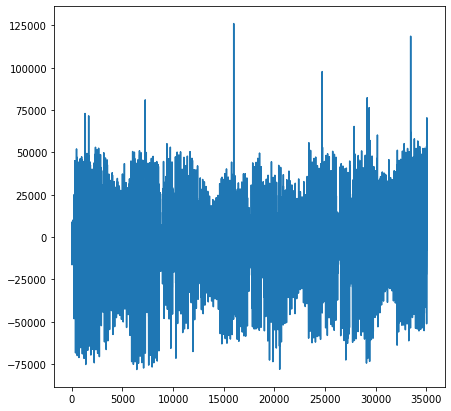

24*7*4


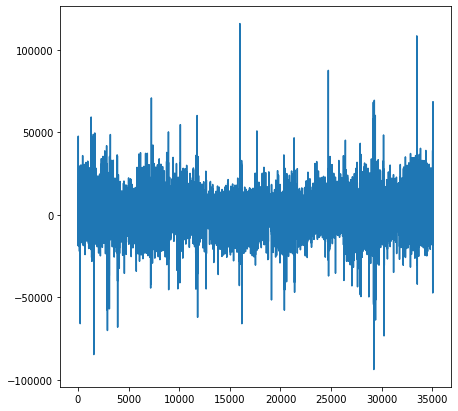

24*365//4


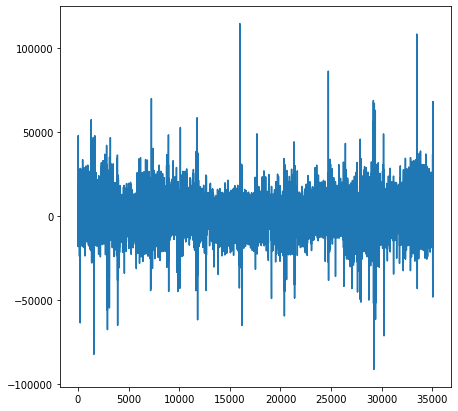

24*365//2


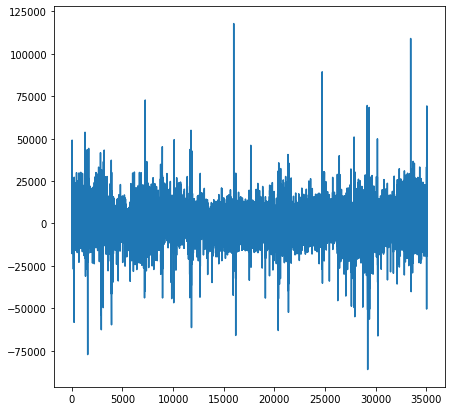

24*365


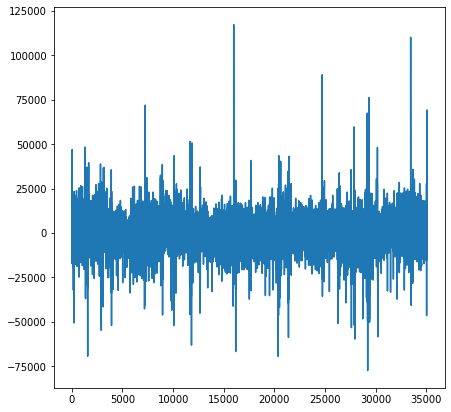

12


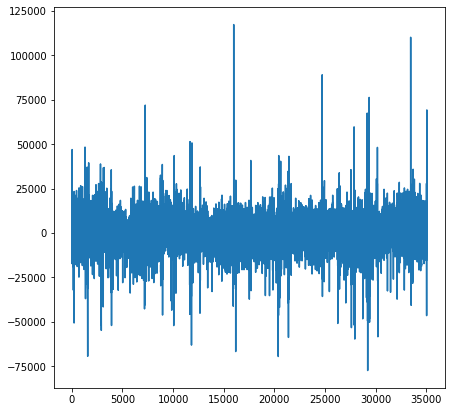

24


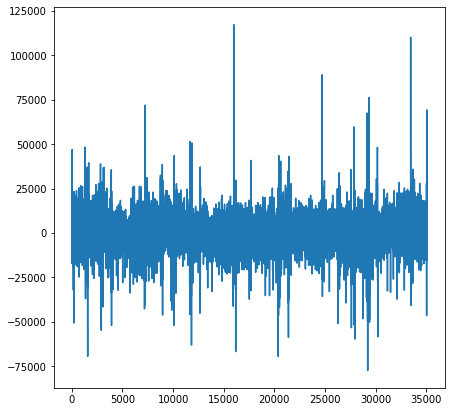

24*7*4


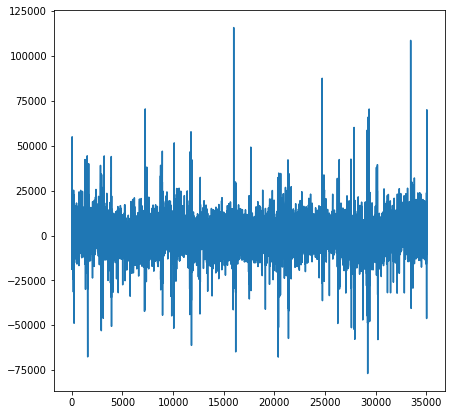

24*365//4


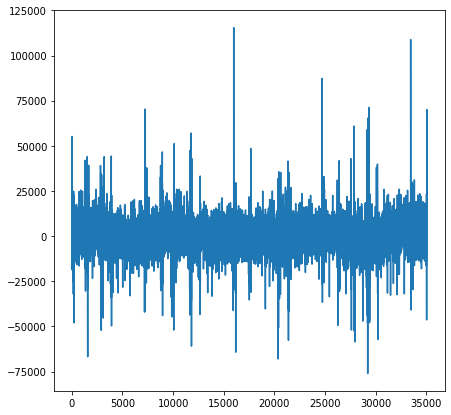

24*365//2


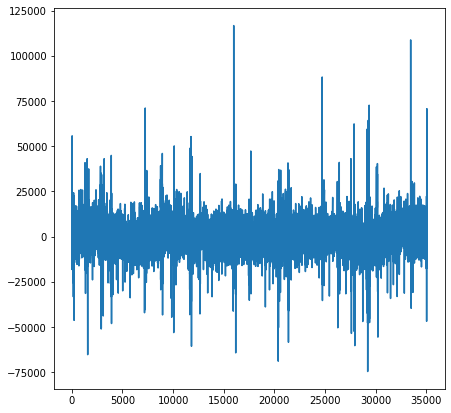

24*365


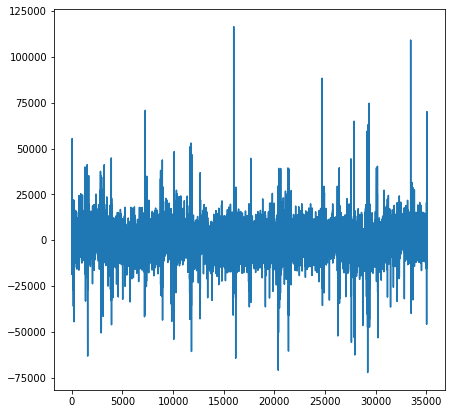

12


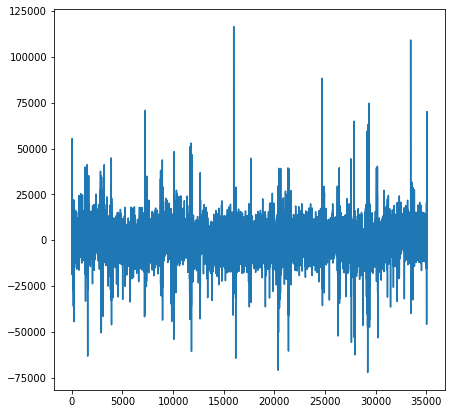

24


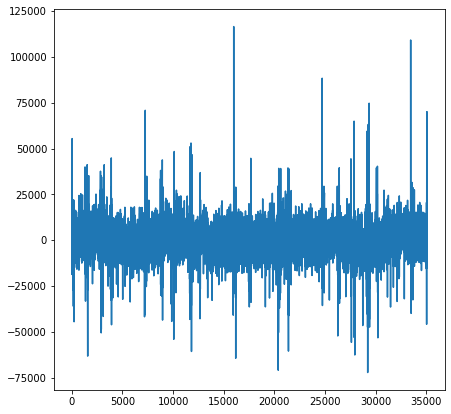

24*7*4


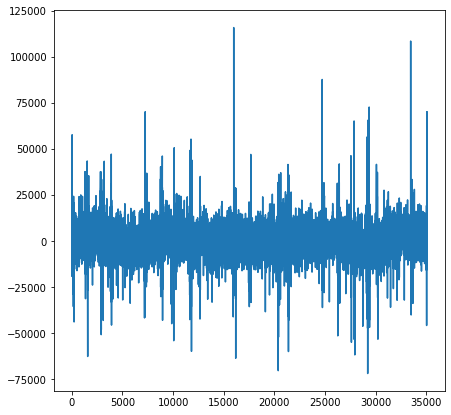

24*365//4


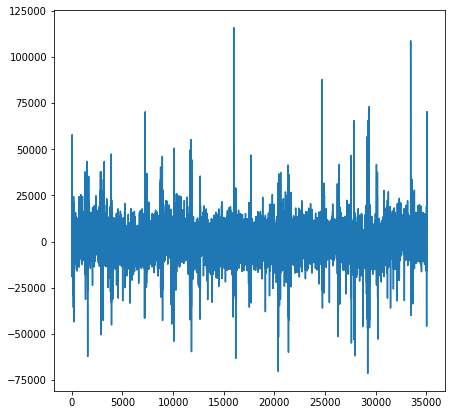

24*365//2


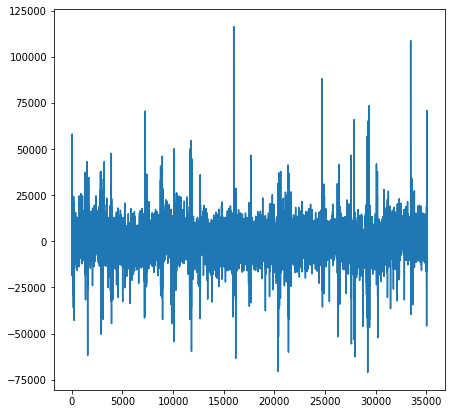

24*365


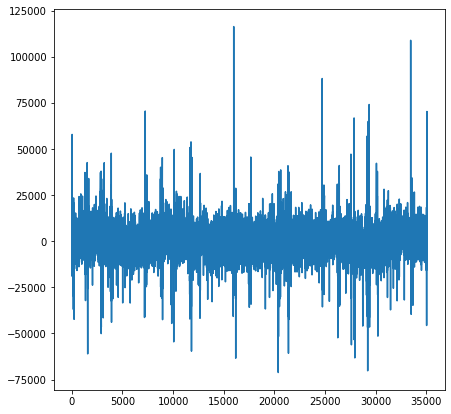

12


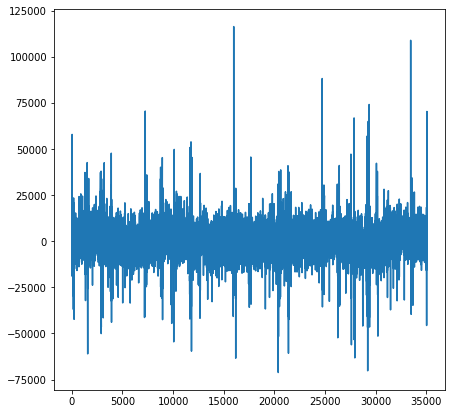

24


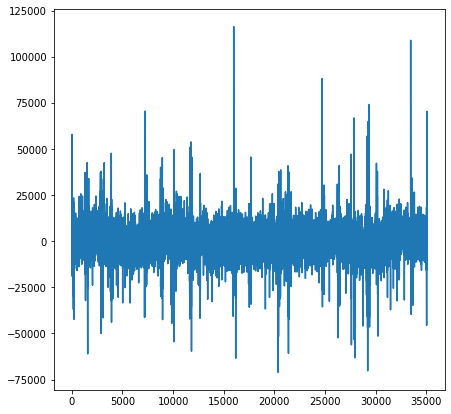

24*7*4


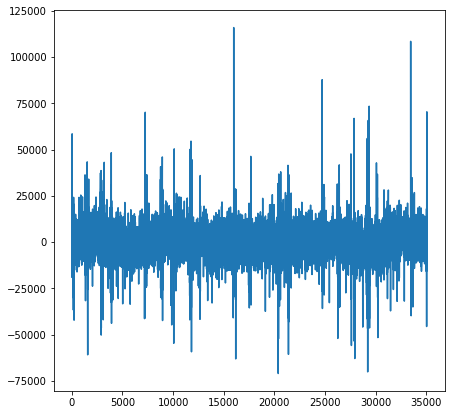

24*365//4


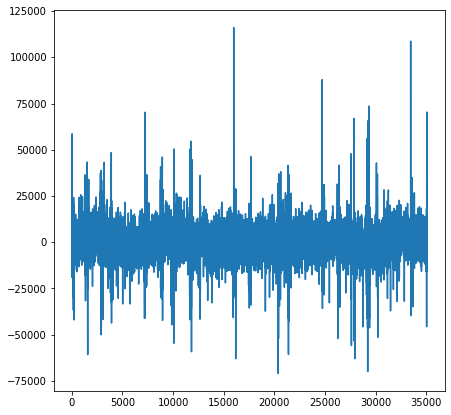

24*365//2


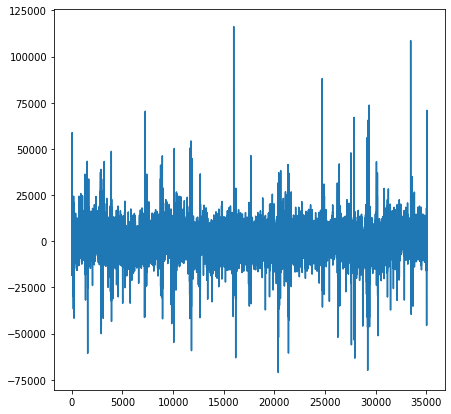

24*365


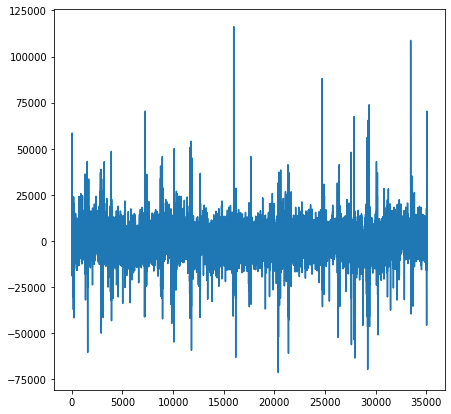

12


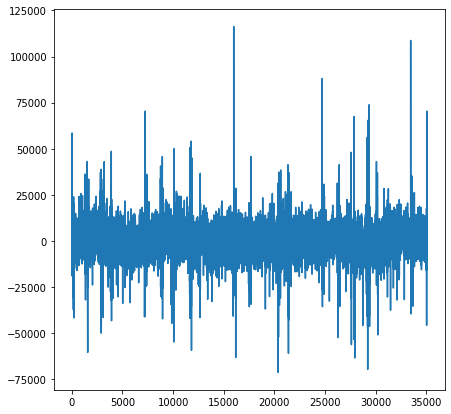

24


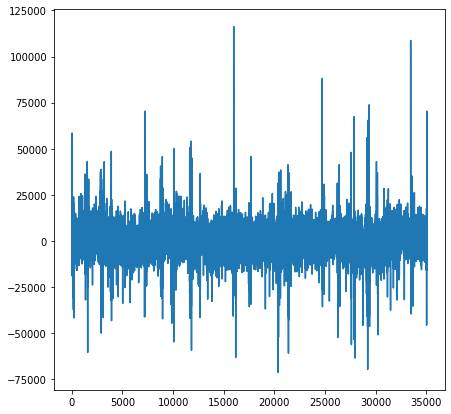

24*7*4


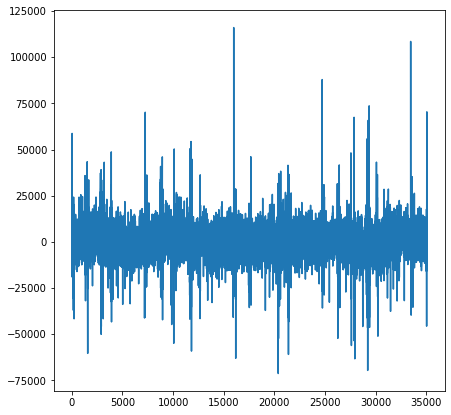

24*365//4


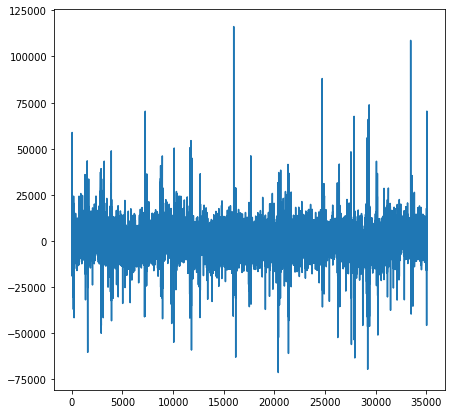

24*365//2


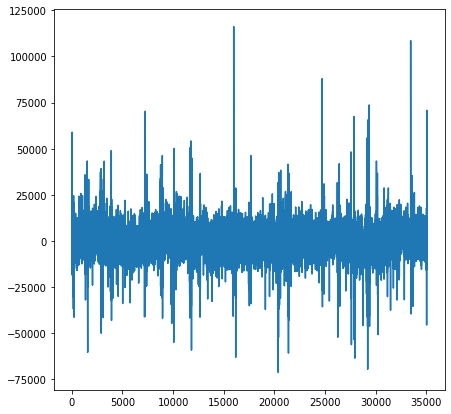

24*365


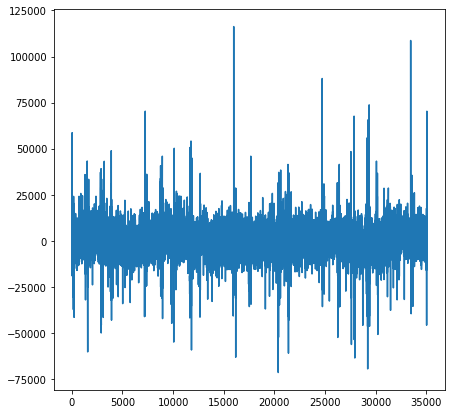

12


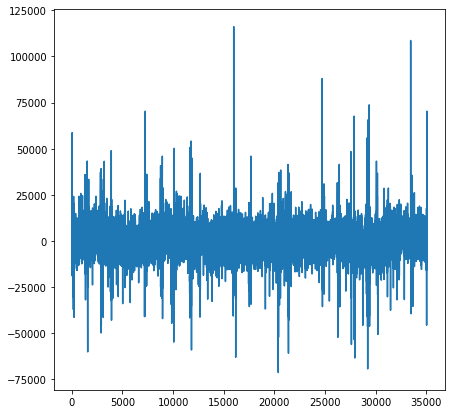

24


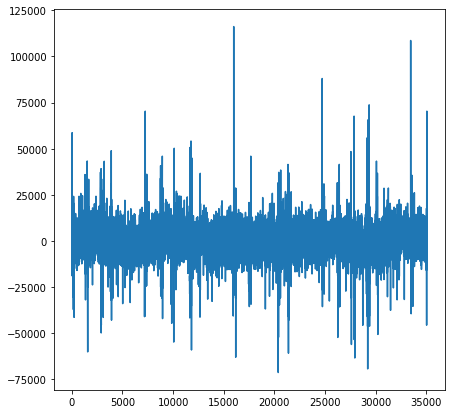

24*7*4


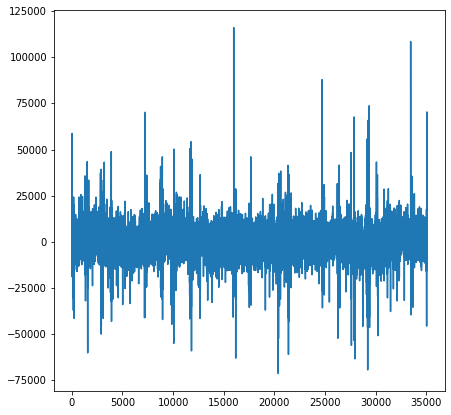

24*365//4


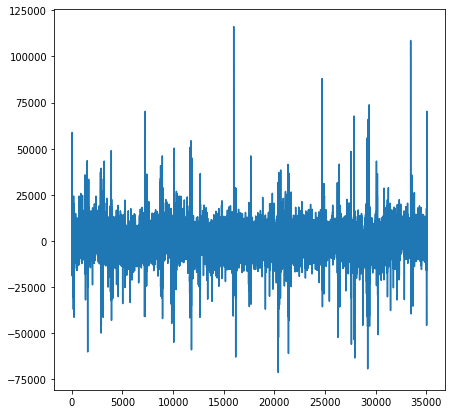

24*365//2


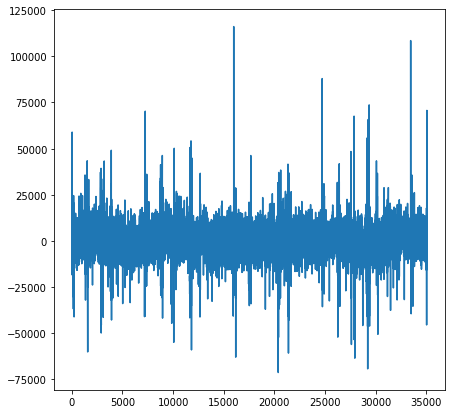

24*365


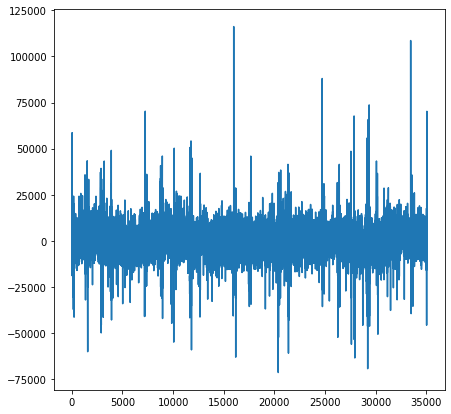

12


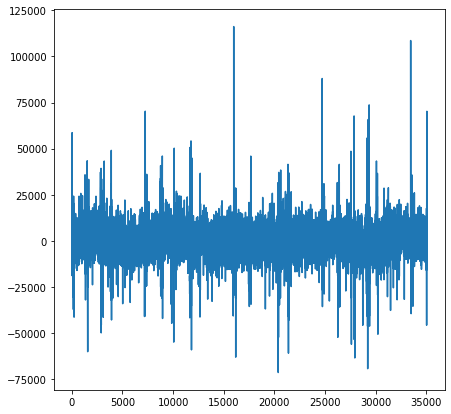

24


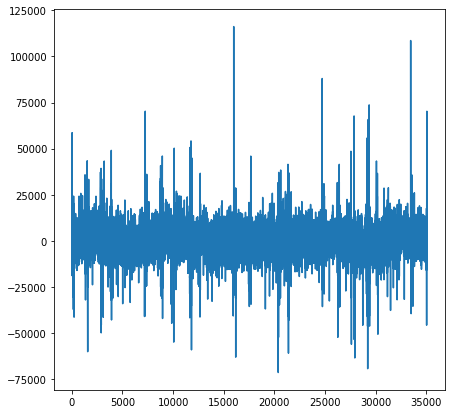

24*7*4


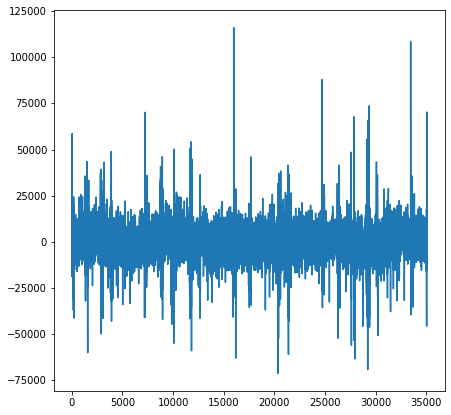

24*365//4


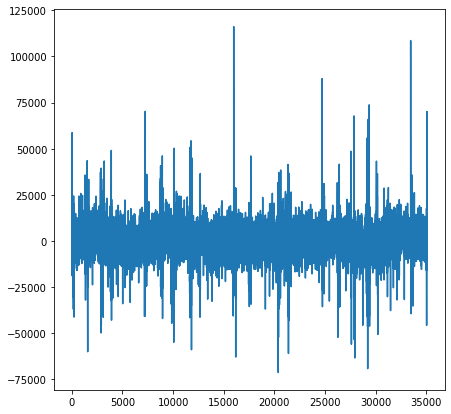

24*365//2


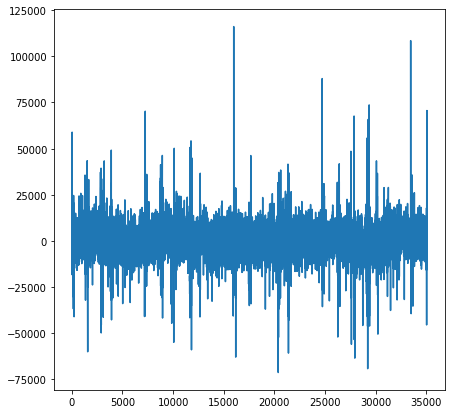

24*365


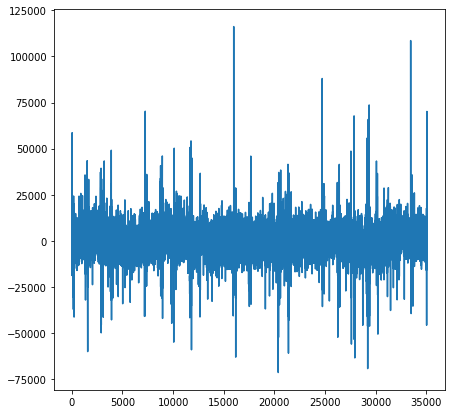

12


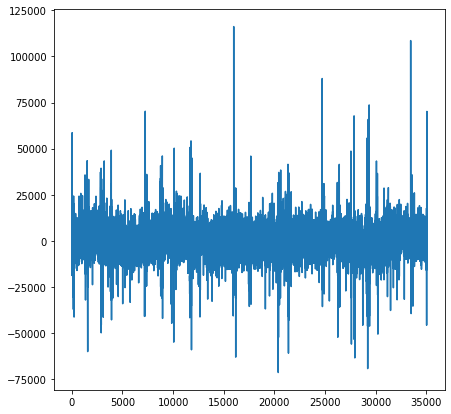

24


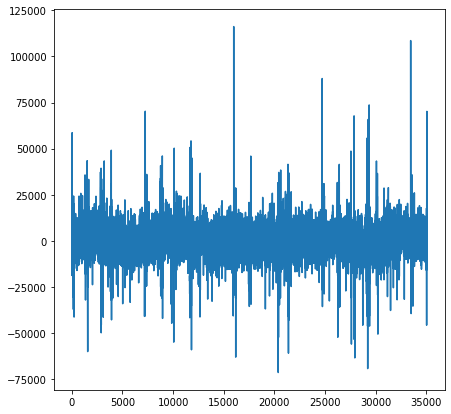

24*7*4


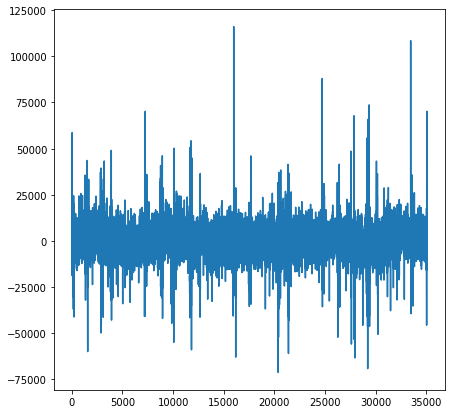

24*365//4


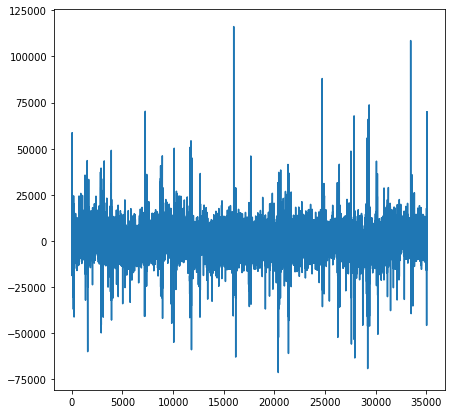

24*365//2


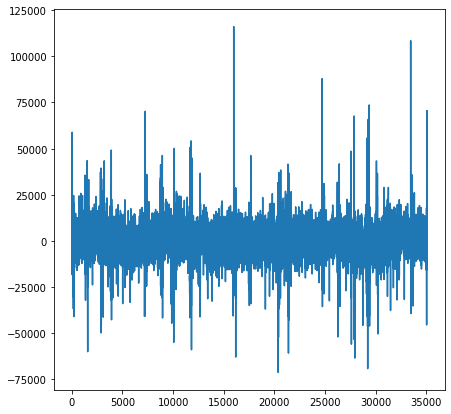

24*365


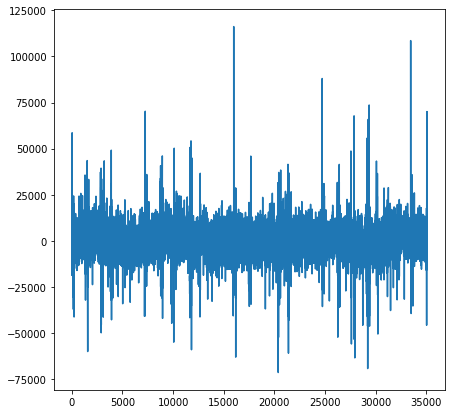

12


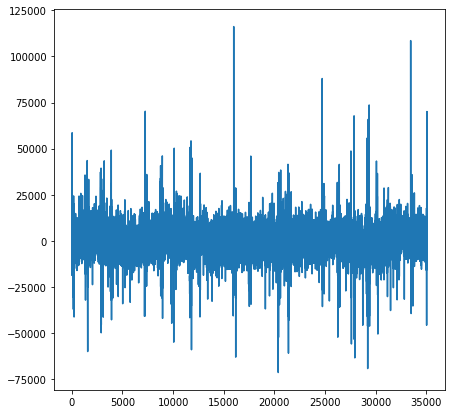

24


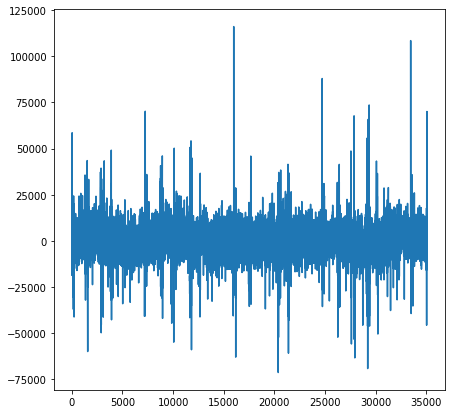

24*7*4


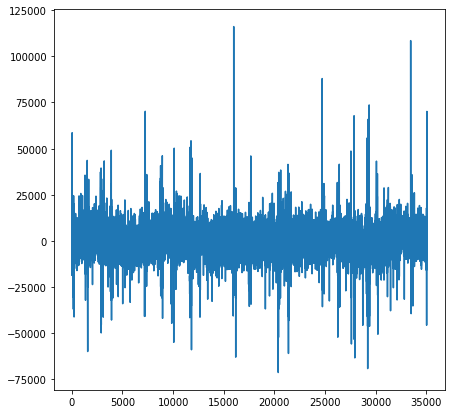

24*365//4


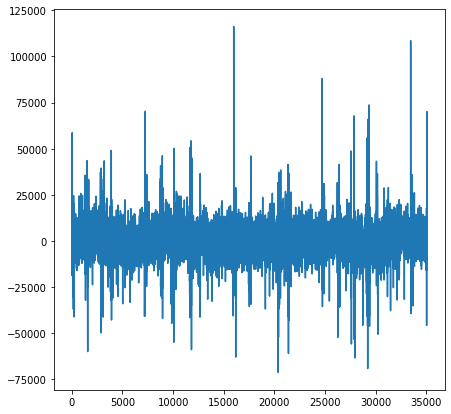

24*365//2


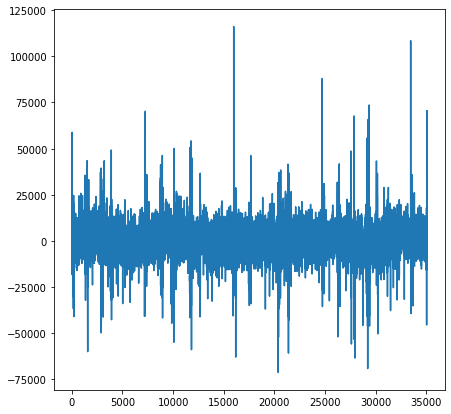

24*365


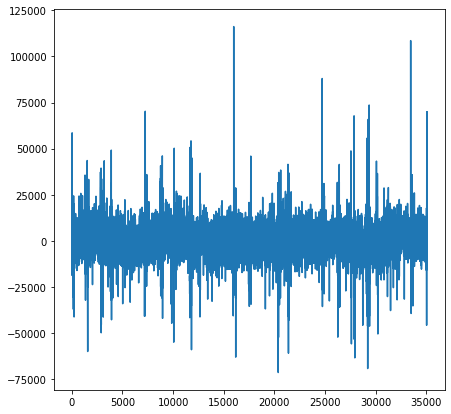

12


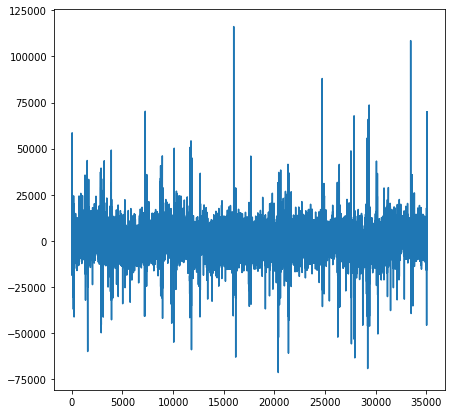

24


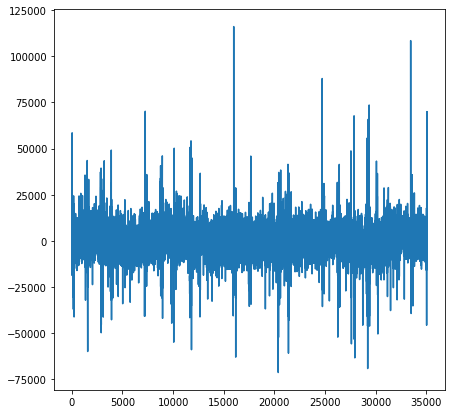

24*7*4


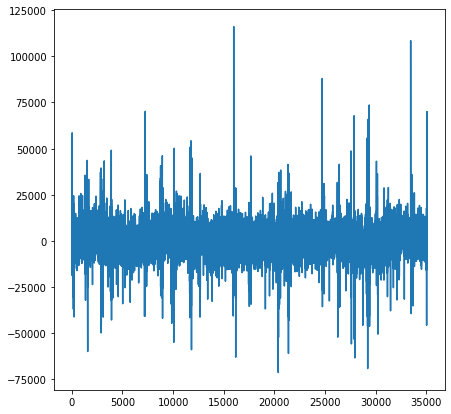

24*365//4


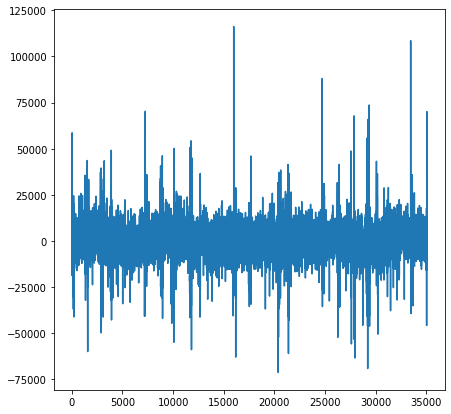

24*365//2


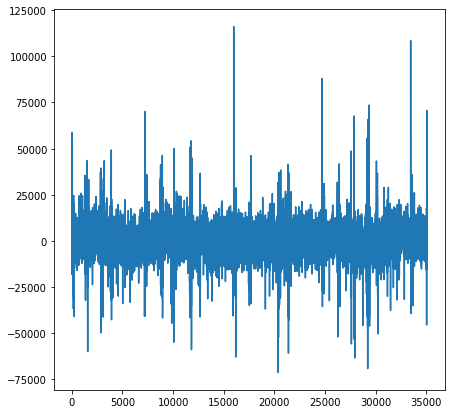

24*365


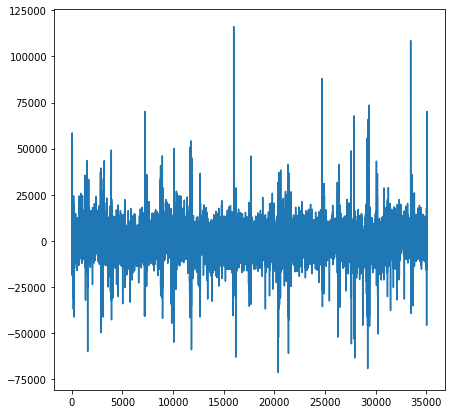

12


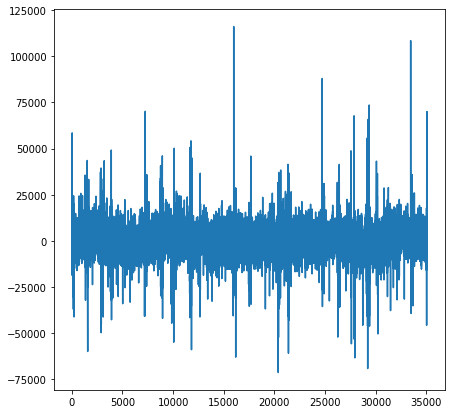

24


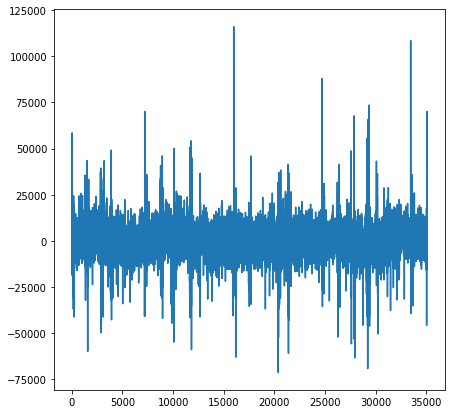

24*7*4


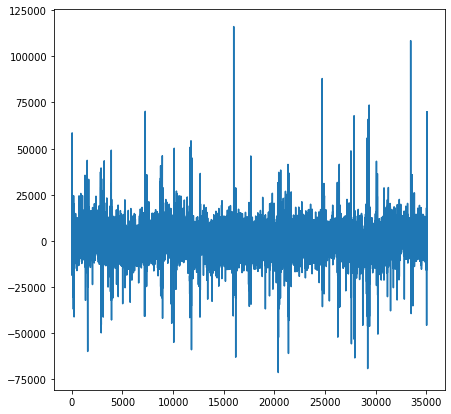

24*365//4


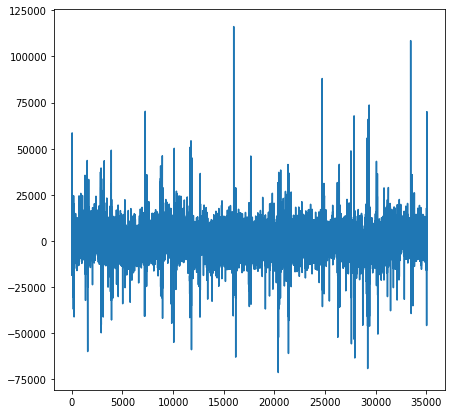

24*365//2


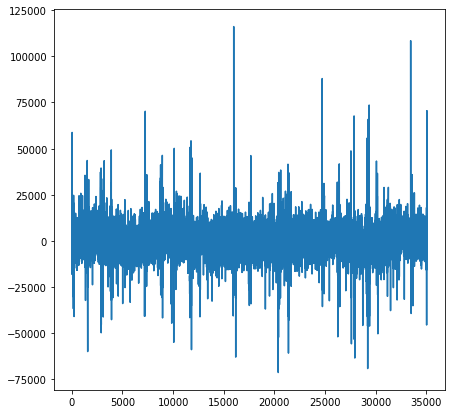

24*365


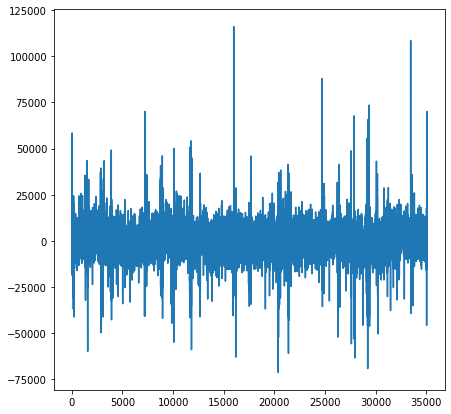

12


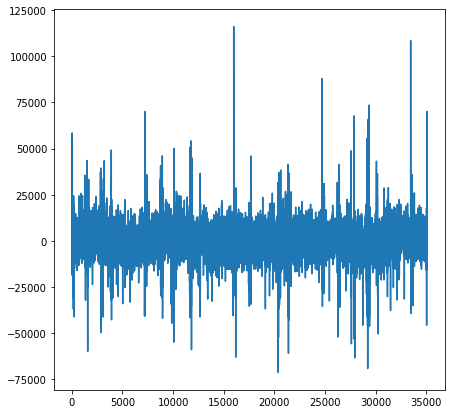

24


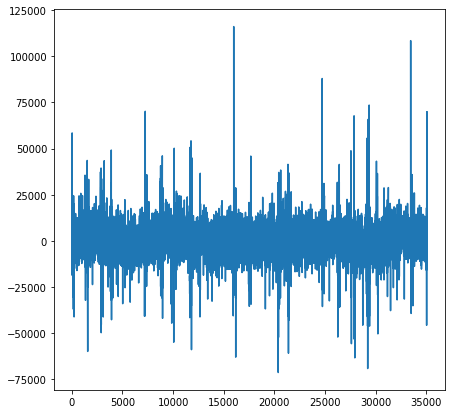

24*7*4


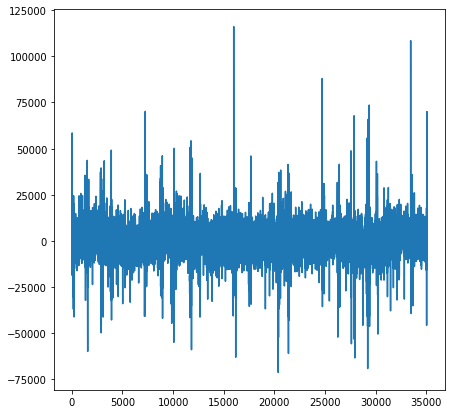

24*365//4


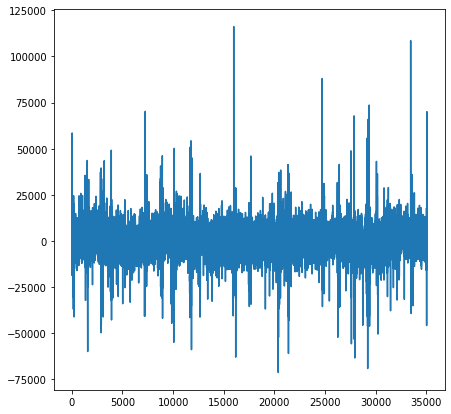

24*365//2


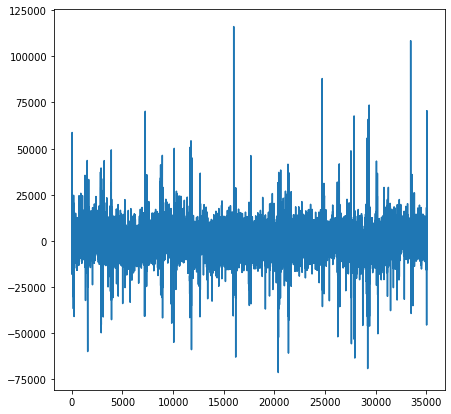

24*365


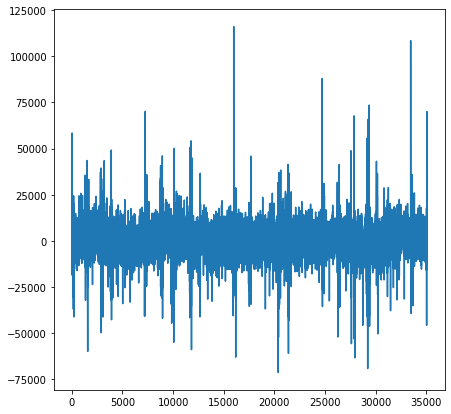

12


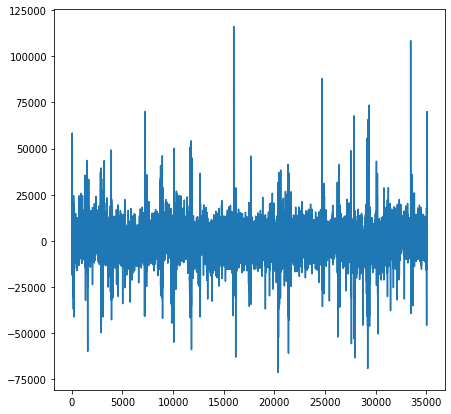

24


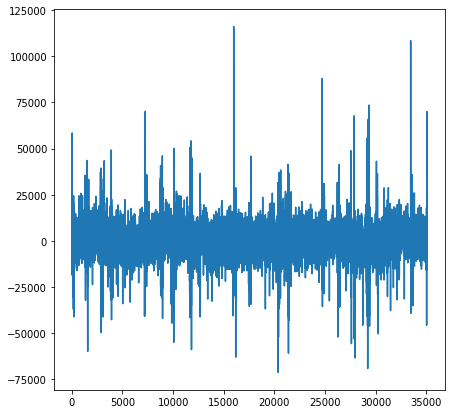

24*7*4


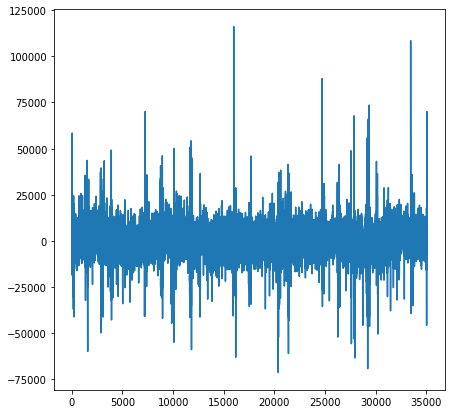

24*365//4


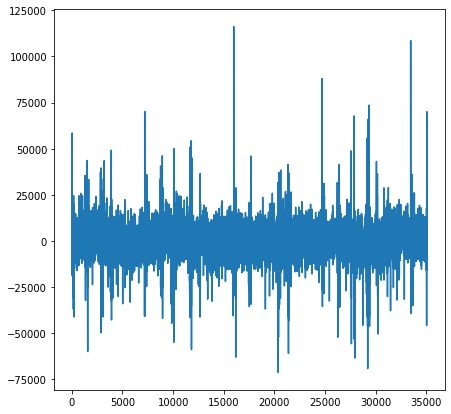

24*365//2


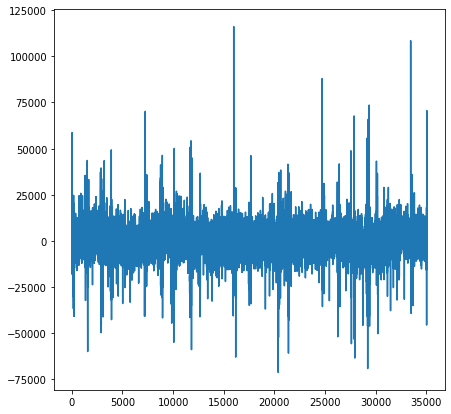

24*365


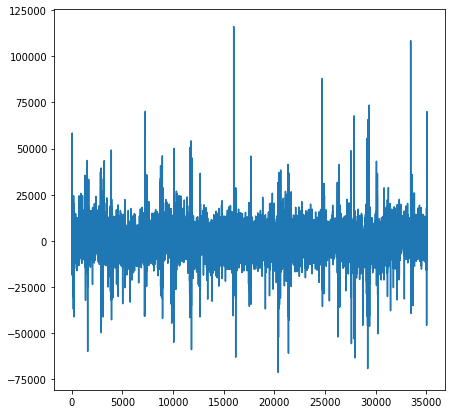

12


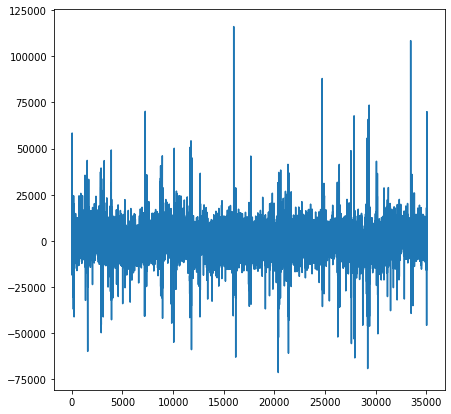

24


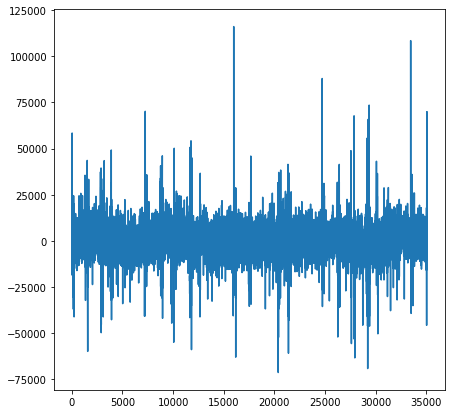

24*7*4


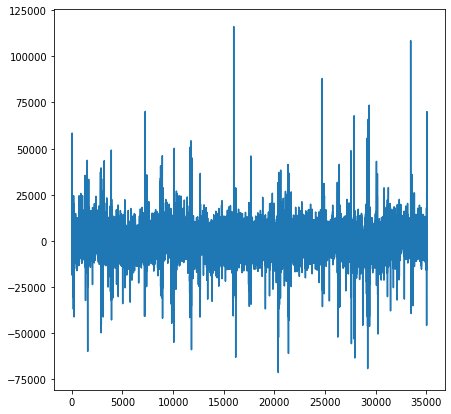

24*365//4


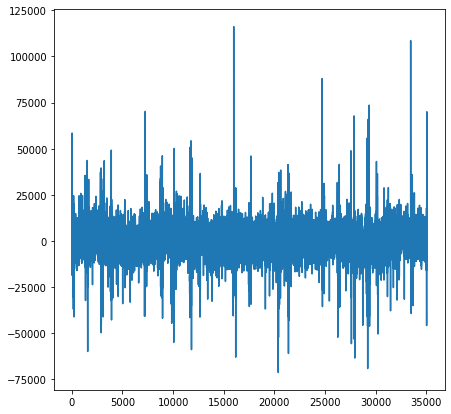

24*365//2


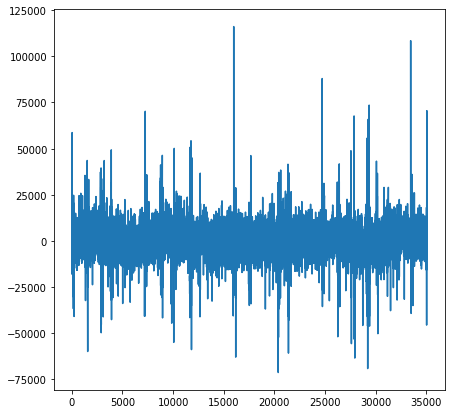

24*365


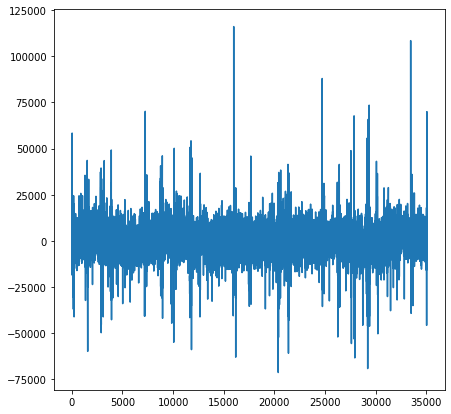

12


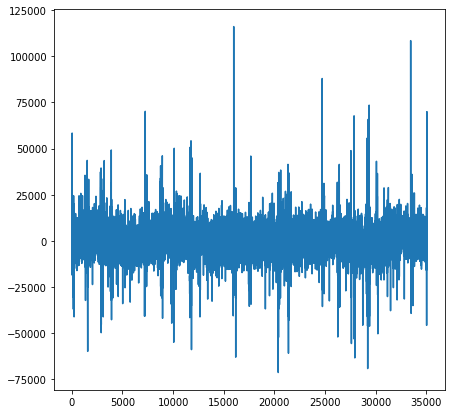

24


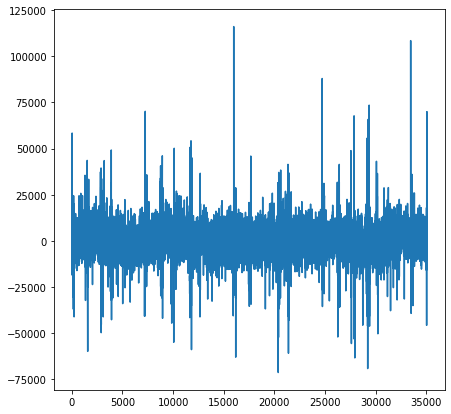

24*7*4


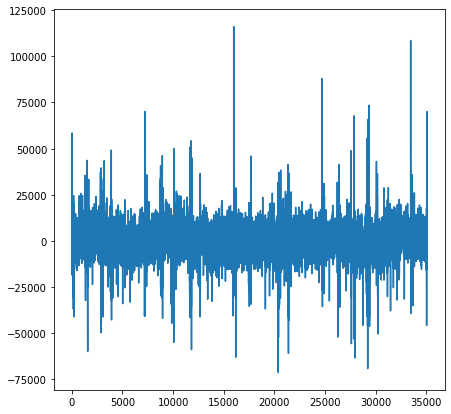

24*365//4


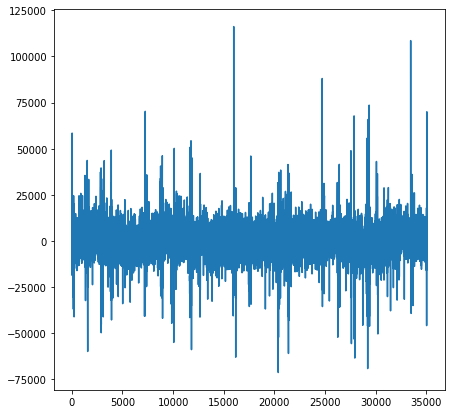

24*365//2


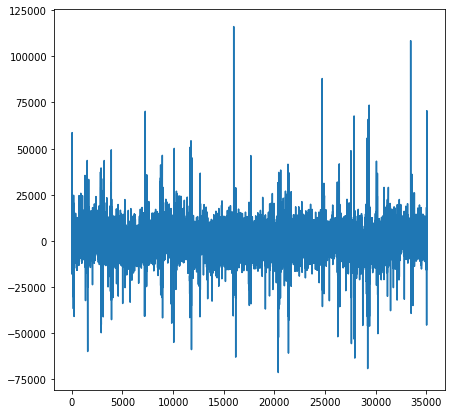

24*365


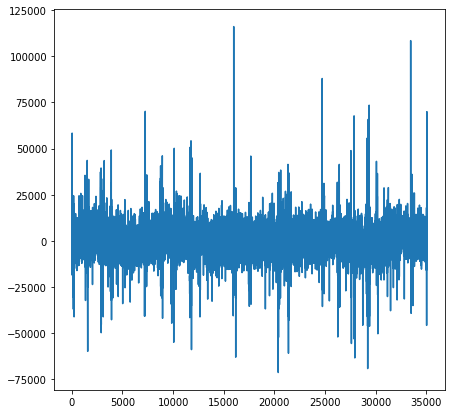

12


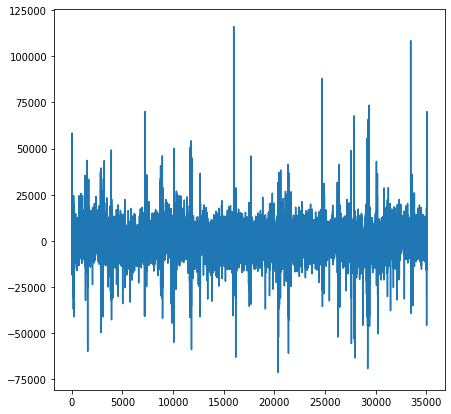

24


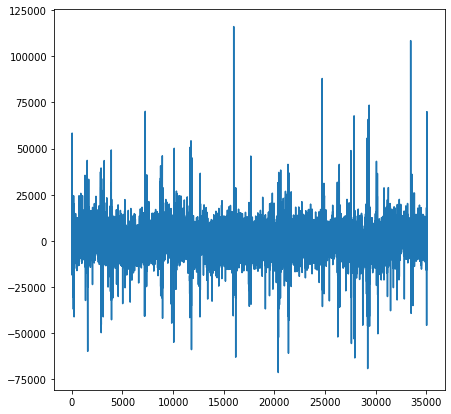

24*7*4


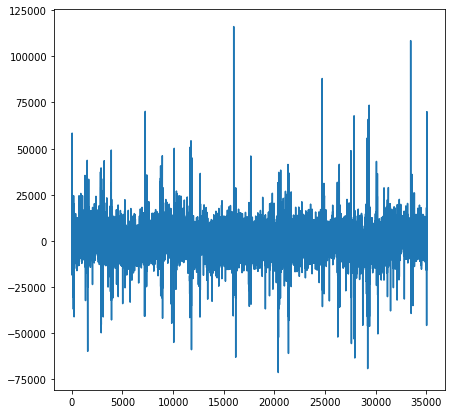

24*365//4


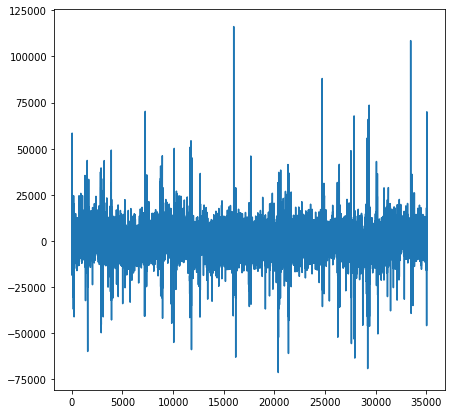

24*365//2


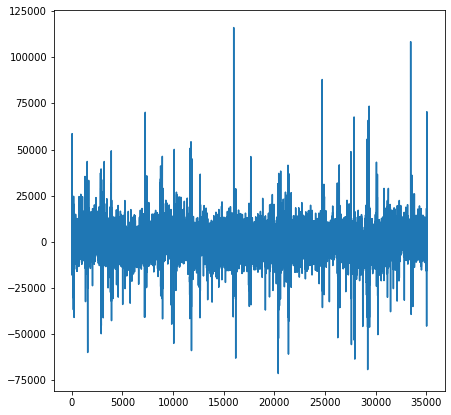

24*365


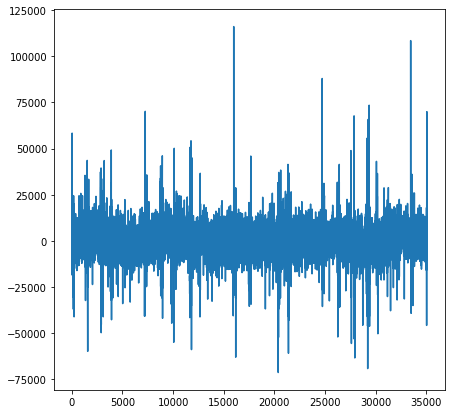

12


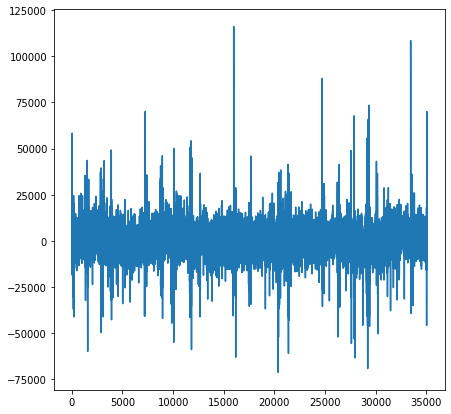

24


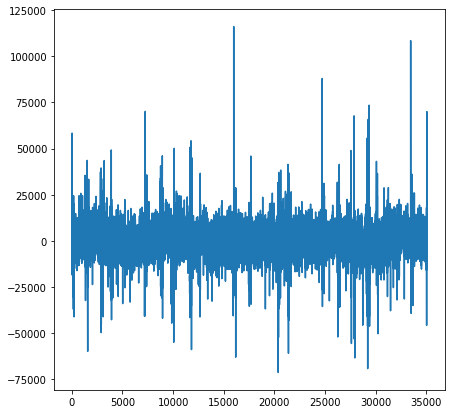

24*7*4


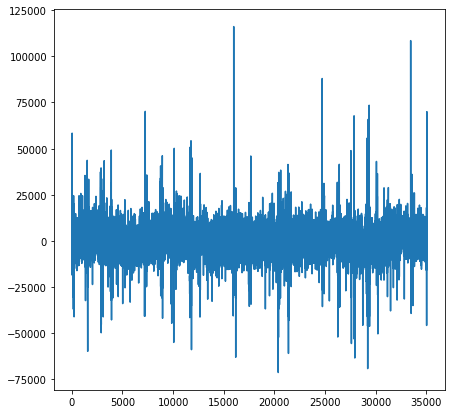

24*365//4


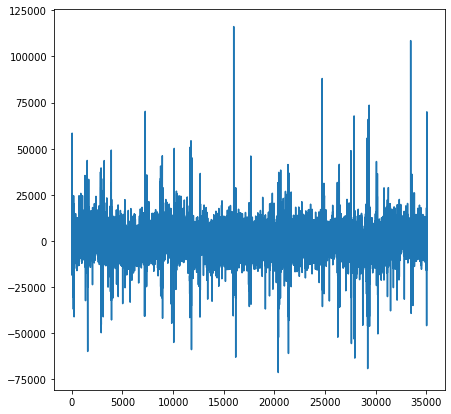

24*365//2


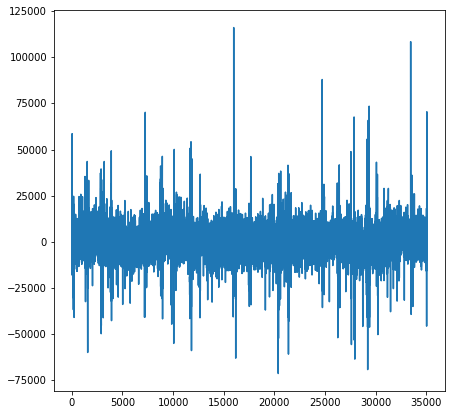

24*365


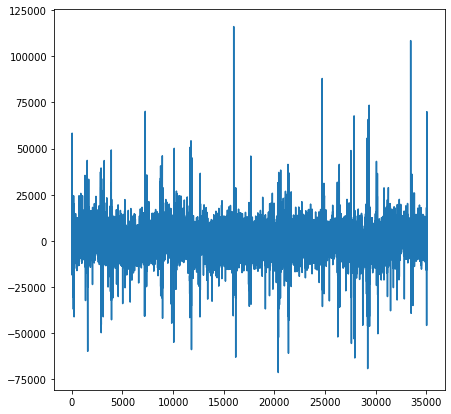

12


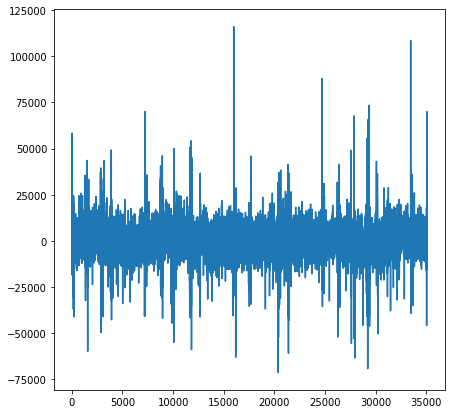

24


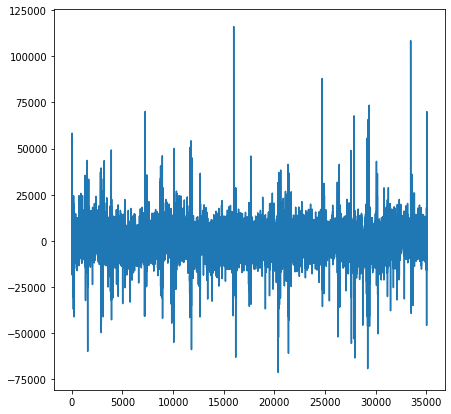

24*7*4


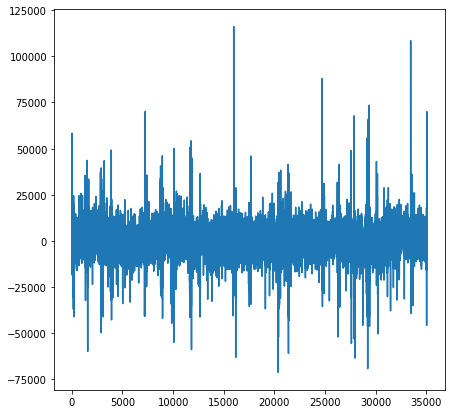

24*365//4


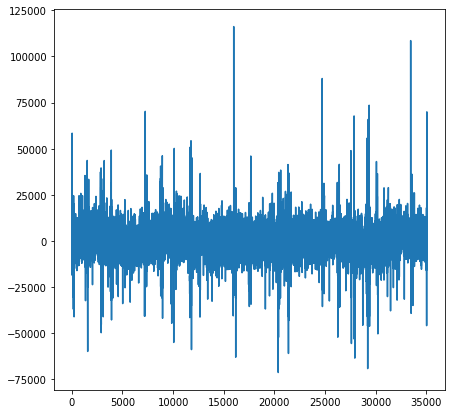

24*365//2


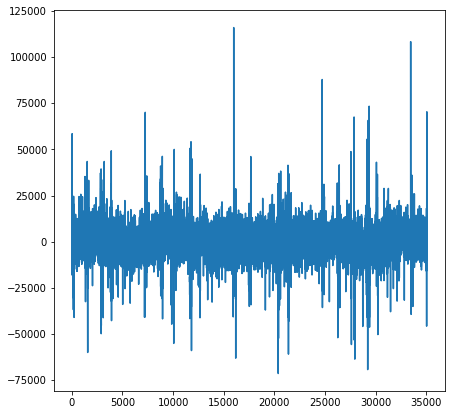

24*365


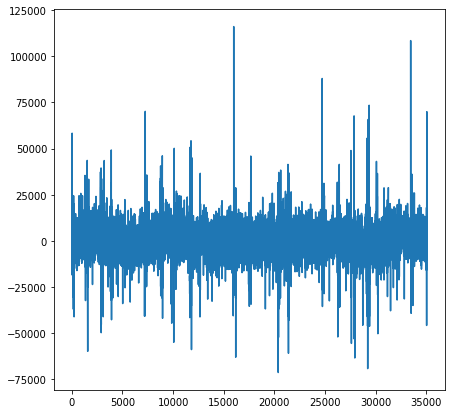

12


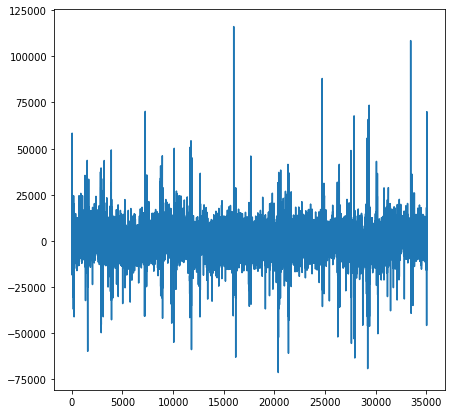

24


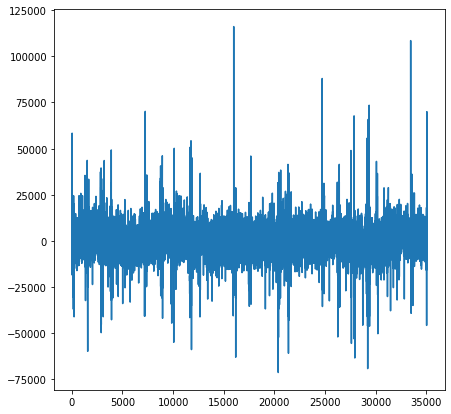

24*7*4


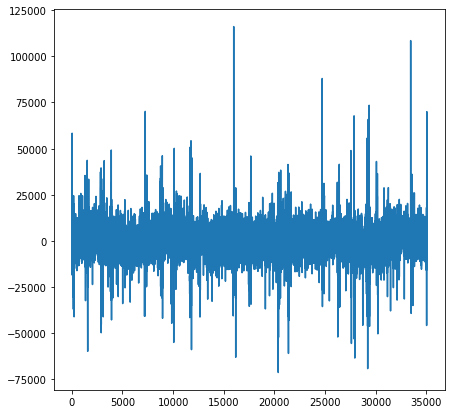

24*365//4


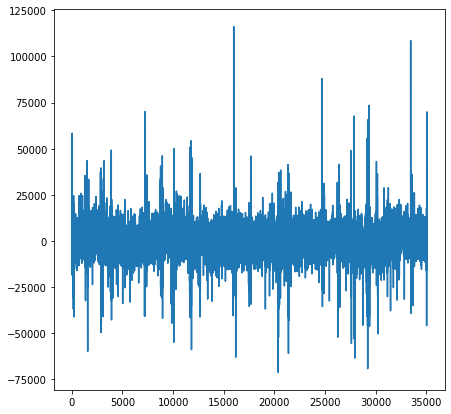

24*365//2


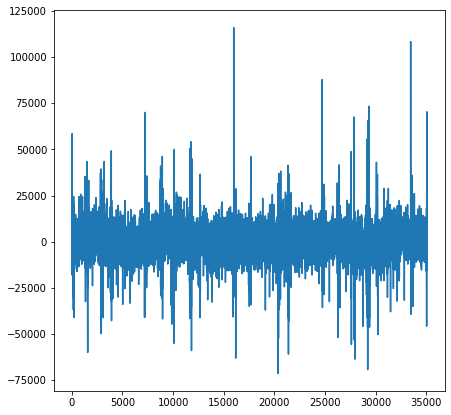

24*365


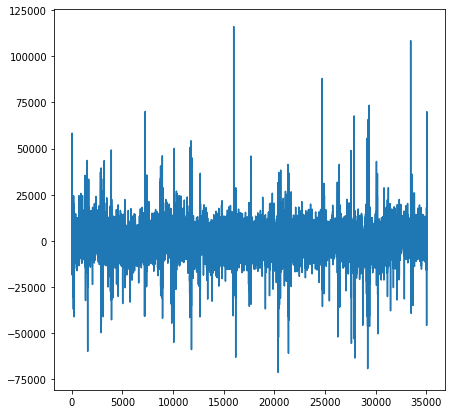

12


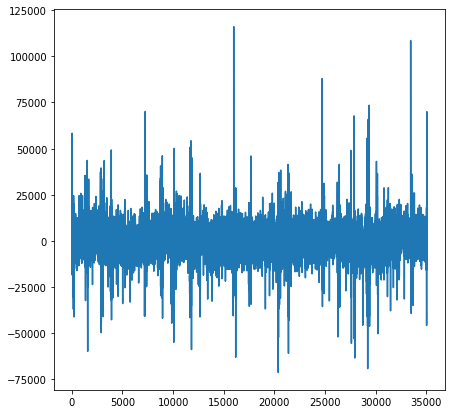

24


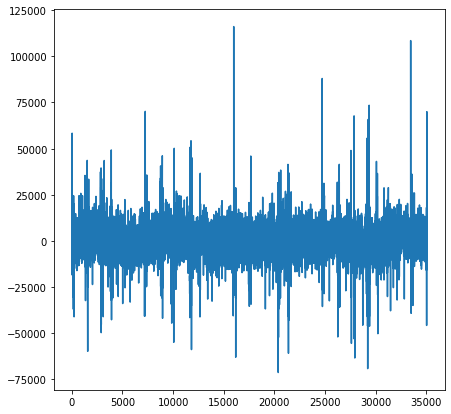

24*7*4


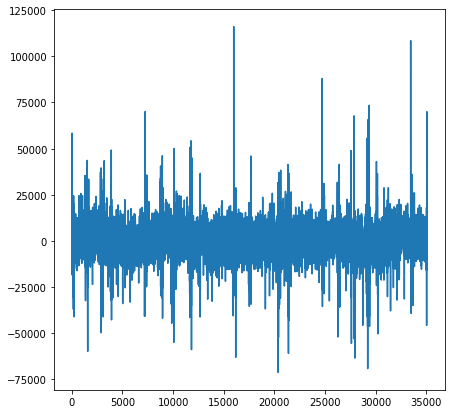

24*365//4


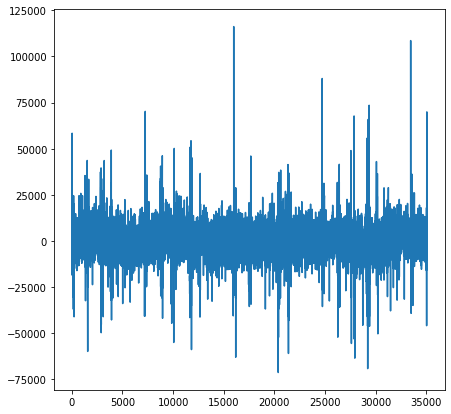

24*365//2


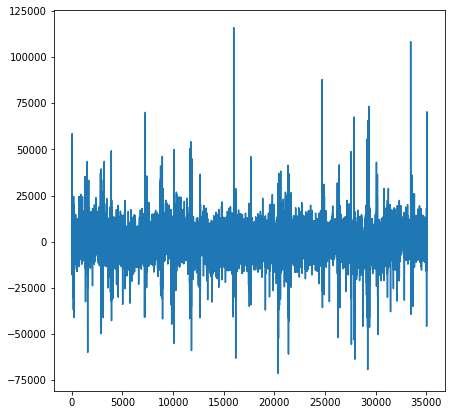

In [104]:
values = train["total"]
periods = ["24*365", "12", "24", "24*7*4", "24*365//4", "24*365//2"]
old_seasonals = {n: [] for n in periods}

for period in periods*20:# + periods[::-1] + periods:
    print(period)
    decomposed = my_decompose(values, period)

    # plt.plot(decomposed.seasonal[:eval(period)])
    # plt.show()

    values -= decomposed.seasonal
    old_seasonals[period].append(decomposed.seasonal)

    plt.plot(values)
    plt.show()

seasonals = dict()
for period, seasonal in old_seasonals.items():
    period = eval(period)
    seasonal = np.sum(seasonal, axis=0)

    sections = np.split(seasonal, range(period, len(seasonal) - len(seasonal)%period, period))
    if len(sections[-1]) != period:
        del sections[-1]
    seasonals[period] = np.mean(sections, axis=0)

8760


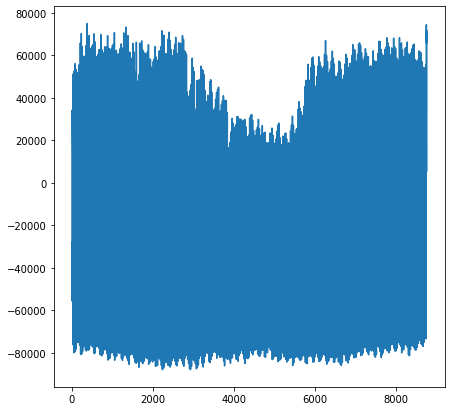

12


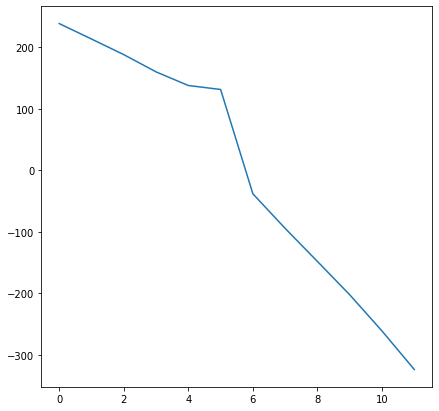

24


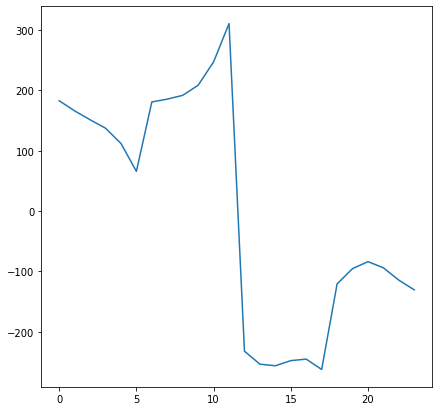

672


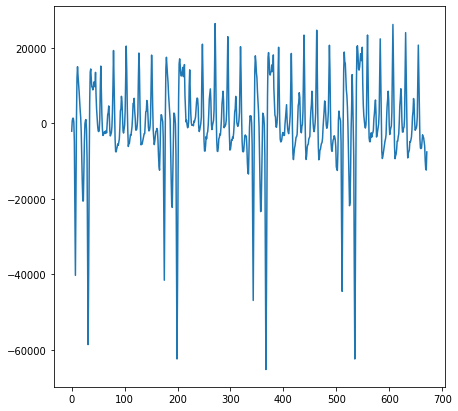

2190


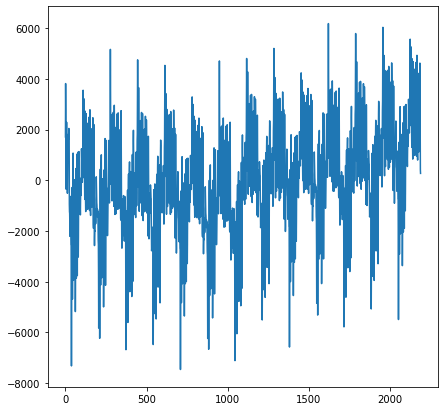

4380


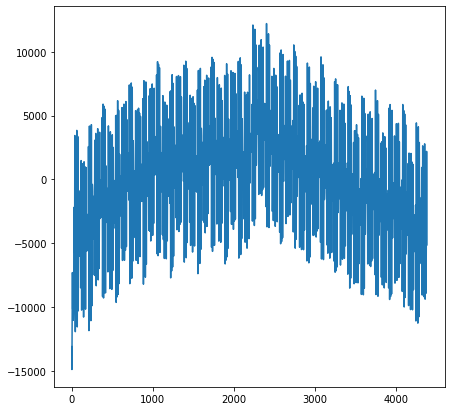

In [105]:
for period, seasonal in seasonals.items():
    print(period)
    plt.plot(seasonal)
    plt.show()

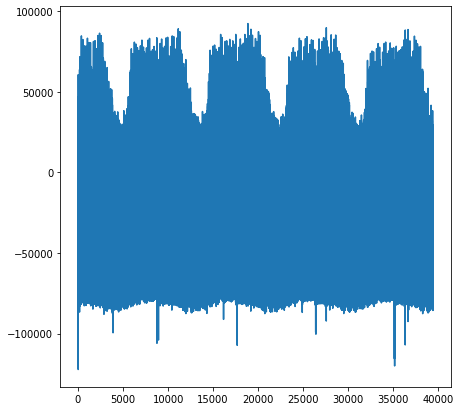

In [106]:
# for period, seasonal in seasonals.items():
#     seasonals = {period: seasonal}
#     if period < 1000:
#         break
# for period, seasonal in seasonals.items():
#     plt.plot(seasonal)
#     plt.show()
#     break


# to_predict = 4344
# neened_len = len(train) + to_predict

# lcm = 1
# for x in seasonals.values():
#     lcm = np.lcm(lcm, len(x))

# if lcm < neened_len:
#     lcm *= np.ceil(neened_len/lcm)
# lcm = int(lcm)

# extended = np.zeros(lcm)
# for period, seasonal in seasonals.items():
#     extended += np.repeat(seasonal, lcm//len(seasonal))

to_predict = 4344
neened_len = len(train) + to_predict

extended = np.zeros(neened_len)
for period, seasonal in seasonals.items():
    extended += np.tile(seasonal, int(np.ceil(neened_len/len(seasonal))))[:neened_len]

plt.plot(extended)
plt.show()

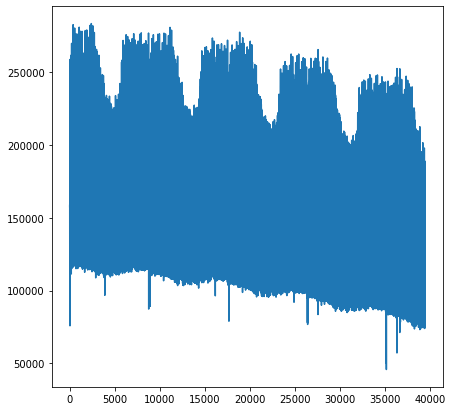

In [107]:
extended += func(np.arange(neened_len), *popt)
extended += global_trend_shift

plt.plot(extended)
plt.show()

In [108]:
# 01.01.2009 00:00:00 по 30.06.2009 23:00:00

last = train["datetime"][len(train)-1]
for _ in range(to_predict):
    last += dt.timedelta(hours=1)
    train.loc[train.shape[0]] = [last] + [pd.NA]*(len(train.columns)-1)
train[-to_predict+1:]

,datetime,total
35065,2009-01-01 01:00:00,<NA>
35066,2009-01-01 02:00:00,<NA>
35067,2009-01-01 03:00:00,<NA>
35068,2009-01-01 04:00:00,<NA>
35069,2009-01-01 05:00:00,<NA>
...,...,...
39403,2009-06-30 19:00:00,<NA>
39404,2009-06-30 20:00:00,<NA>
39405,2009-06-30 21:00:00,<NA>
39406,2009-06-30 22:00:00,<NA>


In [109]:
train["year"] = [date.year for date in train["datetime"]]
train["season"] = [date.month % 4 for date in train["datetime"]]
train["month"] = [date.month for date in train["datetime"]]
train["week_of_year"] = [date.isocalendar().week for date in train["datetime"]]
# train["week_of_month"] = [(date.day + date.replace(day=1).weekday() - 1)//7 for date in train["datetime"]]
train["is_weekend"] = [int(date.weekday() >= 5) for date in train["datetime"]]
train["weekday"] = [date.weekday() for date in train["datetime"]]
train["hour"] = [date.hour for date in train["datetime"]]

In [110]:
set([date.year for date in train["datetime"]])

{2005, 2006, 2007, 2008, 2009}

In [111]:
train["year"] -= 2005
train["year"] /= 4  # so 2009 would work

train["season"] /= 3

train["month"] -= 1
train["month"] /= 11

train["week_of_year"] -= 1
train["week_of_year"] /= 51

# train["week_of_month"] /= 4

train["weekday"] /= 6

train["hour"] /= 23

In [112]:
ind = len(train)-to_predict
X_submit = pd.DataFrame(train[ind:].values, columns=train.columns)
train.drop(train[ind:].index, inplace=True)
del X_submit["total"]
del X_submit["datetime"]
for column in X_submit.columns:
    X_submit[column] = X_submit[column].astype(np.float64)
X_submit

,year,season,month,week_of_year,is_weekend,weekday,hour
0,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.000000
1,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.043478
2,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.086957
3,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.130435
4,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.173913
...,...,...,...,...,...,...,...
4339,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.826087
4340,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.869565
4341,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.913043
4342,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.956522


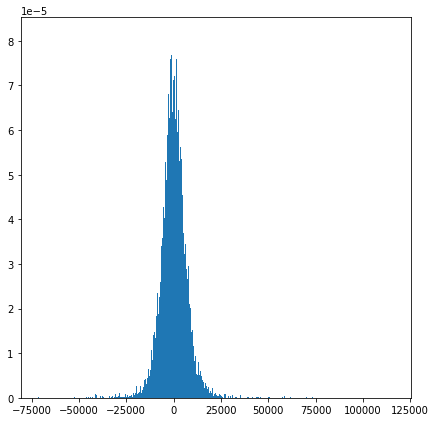

In [113]:
plt.hist(values, 1500, density=True)
plt.show()

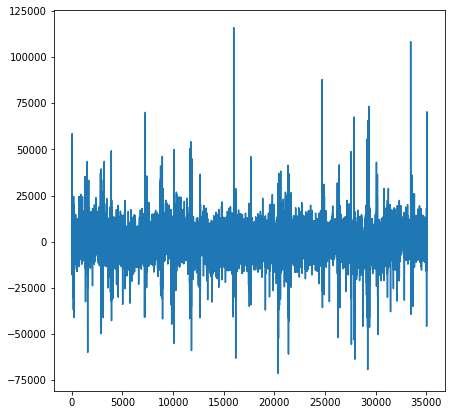

In [148]:
plt.plot(values[:])
plt.show()

[[ 0.00000000e+00 -5.94097658e+03]
 [ 1.00000000e+00 -5.85333785e+03]
 [ 2.00000000e+00 -5.76560844e+03]
 ...
 [ 3.50610000e+04  6.63856600e+03]
 [ 3.50620000e+04  6.69147936e+03]
 [ 3.50630000e+04  6.74474606e+03]]


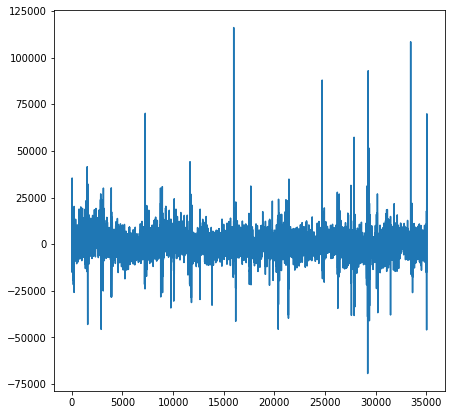

In [184]:
print(lowess(values, np.arange(len(values)), frac=0.004))
train["leftovers"] = values

noise = train["leftovers"]

frac = 0.0002
train["smoothed_leftovers"] = lowess(values, np.arange(len(values)), frac=frac)[:, 1]
plt.plot(train["smoothed_leftovers"])
plt.show()

In [116]:
train.sort_values(by=["season", "month", "is_weekend", "weekday", "hour", "week_of_year", "year"])

,datetime,total,year,season,month,week_of_year,is_weekend,weekday,hour,leftovers,smoothed_leftovers
2232,2005-04-04 00:00:00,-290.66972,0.00,0.0,0.272727,0.254902,0,0.0,0.0,-290.669720,2548.991399
10968,2006-04-03 00:00:00,-638.315563,0.25,0.0,0.272727,0.254902,0,0.0,0.0,-638.315563,832.563254
19704,2007-04-02 00:00:00,6376.592542,0.50,0.0,0.272727,0.254902,0,0.0,0.0,6376.592542,-1930.914788
2400,2005-04-11 00:00:00,563.879499,0.00,0.0,0.272727,0.274510,0,0.0,0.0,563.879499,4636.404306
11136,2006-04-10 00:00:00,-1206.759023,0.25,0.0,0.272727,0.274510,0,0.0,0.0,-1206.759023,2192.161230
...,...,...,...,...,...,...,...,...,...,...,...
7943,2005-11-27 23:00:00,-5525.051723,0.00,1.0,0.909091,0.901961,1,1.0,1.0,-5525.051723,-325.526593
16679,2006-11-26 23:00:00,4479.629128,0.25,1.0,0.909091,0.901961,1,1.0,1.0,4479.629128,732.281592
25415,2007-11-25 23:00:00,1479.046661,0.50,1.0,0.909091,0.901961,1,1.0,1.0,1479.046661,1971.619376
34151,2008-11-23 23:00:00,-1911.385459,0.75,1.0,0.909091,0.901961,1,1.0,1.0,-1911.385459,300.073691


In [117]:
train.describe()

,year,season,month,week_of_year,is_weekend,weekday,hour,leftovers,smoothed_leftovers
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,0.375257,0.498745,0.502085,0.499685,0.286105,0.499886,0.500000,193.320584,202.099990
std,0.279589,0.373802,0.313523,0.295280,0.451946,0.333538,0.300969,7421.714591,2144.047932
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-71469.103008,-5940.976581
25%,0.250000,0.000000,0.272727,0.235294,0.000000,0.166667,0.250000,-3639.665957,-1218.324145
50%,0.500000,0.333333,0.545455,0.490196,0.000000,0.500000,0.500000,81.964959,168.420045
75%,0.750000,1.000000,0.818182,0.764706,1.000000,0.833333,0.750000,4091.869823,1472.116609
max,0.750000,1.000000,1.000000,1.019608,1.000000,1.000000,1.000000,116109.399134,10314.763883


In [118]:
train.corr()

,year,season,month,week_of_year,is_weekend,weekday,hour,leftovers,smoothed_leftovers
year,1.000000e+00,4.124187e-04,-1.204013e-03,-5.821027e-03,-3.289666e-03,-3.210946e-03,4.849968e-16,-0.005666,0.044454
season,4.124187e-04,1.000000e+00,-6.780733e-02,-5.912926e-02,-1.926463e-03,1.676365e-03,-2.014111e-16,-0.000076,-0.010950
month,-1.204013e-03,-6.780733e-02,1.000000e+00,9.701007e-01,4.134813e-03,5.804036e-03,-8.924218e-17,0.006426,0.012841
week_of_year,-5.821027e-03,-5.912926e-02,9.701007e-01,1.000000e+00,6.006435e-03,6.484008e-03,-9.069401e-17,-0.000655,-0.010560
is_weekend,-3.289666e-03,-1.926463e-03,4.134813e-03,6.006435e-03,1.000000e+00,7.910701e-01,-8.554814e-18,-0.000161,0.010199
weekday,-3.210946e-03,1.676365e-03,5.804036e-03,6.484008e-03,7.910701e-01,1.000000e+00,-1.147355e-18,-0.000124,-0.006281
hour,4.849968e-16,-2.014111e-16,-8.924218e-17,-9.069401e-17,-8.554814e-18,-1.147355e-18,1.000000e+00,0.000040,0.001210
leftovers,-5.665644e-03,-7.552506e-05,6.426374e-03,-6.549660e-04,-1.613321e-04,-1.243587e-04,3.981586e-05,1.000000,0.352807
smoothed_leftovers,4.445397e-02,-1.094986e-02,1.284134e-02,-1.055971e-02,1.019860e-02,-6.281494e-03,1.210277e-03,0.352807,1.000000


In [119]:
# plt.plot(train["season"])
# plt.plot(train["month"])
# plt.plot(train["is_weekend"][:24*7*2])
# plt.plot(train["weekday"][:24*7*2])
# plt.plot(train["hour"][:24*3])

In [120]:
feature_columns = []

numeric_year = tf.feature_column.numeric_column("year")
year = bucketize_column(numeric_year, -0.1, 1.1, 5+1)
feature_columns.append(year)

numeric_season = tf.feature_column.numeric_column("season")
season = bucketize_column(numeric_season, -0.1, 1.1, 4+1)
feature_columns.append(season)

numeric_month = tf.feature_column.numeric_column("month")
month = bucketize_column(numeric_month, -0.1, 1.1, 12+1)
feature_columns.append(month)

numeric_week_of_year = tf.feature_column.numeric_column("week_of_year")
week_of_year = bucketize_column(numeric_week_of_year, -0.1, 1.1, 52+1)
feature_columns.append(week_of_year)

numeric_is_weekend = tf.feature_column.numeric_column("is_weekend")
is_weekend = bucketize_column(numeric_is_weekend, -0.1, 1.1, 2+1)
feature_columns.append(is_weekend)

numeric_weekday = tf.feature_column.numeric_column("weekday")
weekday = bucketize_column(numeric_weekday, -0.1, 1.1, 7+1)
feature_columns.append(weekday)

numeric_hour = tf.feature_column.numeric_column("hour")
hour = bucketize_column(numeric_hour, -0.1, 1.1, 24+1)
feature_columns.append(hour)

season_x_weekday = tf.feature_column.crossed_column([season, weekday], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(season_x_weekday)
feature_columns.append(crossed_feature)

weekday_x_hour = tf.feature_column.crossed_column([weekday, hour], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(weekday_x_hour)
feature_columns.append(crossed_feature)

month_x_weekday = tf.feature_column.crossed_column([month, weekday], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(month_x_weekday)
feature_columns.append(crossed_feature)

Epoch 1/600


C:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


50/50 [==============================] - 1s 7ms/step - loss: -0.0047 - tf_error: -0.0043 - val_loss: 0.1120 - val_tf_error: 0.1148
Epoch 2/600
50/50 [==============================] - 0s 4ms/step - loss: -0.0047 - tf_error: -0.0050 - val_loss: 0.1120 - val_tf_error: 0.1148
Epoch 3/600
50/50 [==============================] - 0s 2ms/step - loss: -0.0047 - tf_error: -0.0051 - val_loss: 0.1120 - val_tf_error: 0.1147
Epoch 4/600
50/50 [==============================] - 0s 3ms/step - loss: -0.0047 - tf_error: -0.0050 - val_loss: 0.1120 - val_tf_error: 0.1147
Epoch 5/600
50/50 [==============================] - 0s 2ms/step - loss: -0.0047 - tf_error: -0.0046 - val_loss: 0.1120 - val_tf_error: 0.1147
Epoch 6/600
50/50 [==============================] - 0s 2ms/step - loss: -0.0048 - tf_error: -0.0043 - val_loss: 0.1120 - val_tf_error: 0.1147
Epoch 7/600
50/50 [==============================] - 0s 2ms/step - loss: -0.0048 - tf_error: -0.0048 - val_loss: 0.1120 - val_tf_error: 0.1147
Epoch 8/600

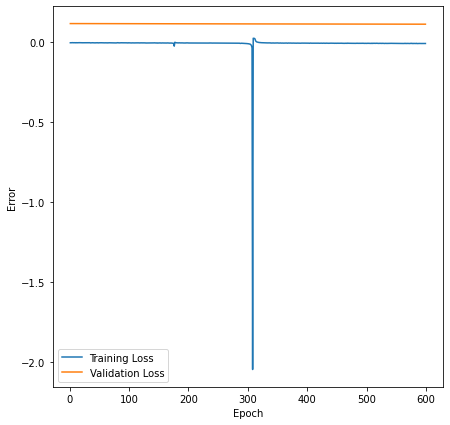

In [168]:
learning_rate = 0.00001
# regularization_rate = 0.01
epochs = 600
batch_size = 600
validation_split = 0.15

selected = list(train.columns)
selected.remove("datetime")
selected.remove("total")
selected.remove("leftovers")
selected.remove("smoothed_leftovers")
#label_name = "smoothed_leftovers"
label_name = "leftovers"

on_full_data = True
if on_full_data:
    X_train, y_train = train[selected], train[label_name]
else:
    X_train, X_test, y_train, y_test = train_test_split(train[selected], train[label_name], shuffle=True, test_size=0.1)

feature_cross_feature_layer = layers.DenseFeatures(feature_columns)#, kernel_regularizer=regularizers.L1(regularization_rate))
my_model = create_model(learning_rate, feature_cross_feature_layer)
epochs, rmse, history = train_model(
    my_model, X_train, y_train, epochs, batch_size, validation_split)

# ['loss', 'tf_error', 'val_loss', 'val_tf_error']
plot_the_loss_curves(epochs, history["tf_error"],
                    history["val_tf_error"])

# epochs, rmse = train_model(my_model, train[selected], epochs, batch_size, label_name)
# plot_the_loss_curve(epochs, rmse)

#print("\n: Evaluate the new model against the test set:")
#evaluate_model(my_model, X_test, y_test, batch_size)

In [122]:
train[selected]['year']

0        0.00
1        0.00
2        0.00
3        0.00
4        0.00
         ... 
35059    0.75
35060    0.75
35061    0.75
35062    0.75
35063    0.75
Name: year, Length: 35064, dtype: float64

In [123]:
X_submit['year']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
4339    1.0
4340    1.0
4341    1.0
4342    1.0
4343    1.0
Name: year, Length: 4344, dtype: float64

In [169]:
pd.concat([train[selected], X_submit])['year']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4339    1.0
4340    1.0
4341    1.0
4342    1.0
4343    1.0
Name: year, Length: 39408, dtype: float64

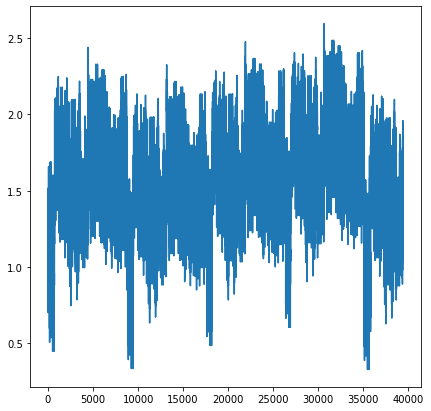

In [170]:
prediction = predict_model(my_model, pd.concat([train[selected], X_submit]), batch_size).T[0]
plt.plot(prediction)
plt.show()

In [147]:
prediction

array([1.5260469, 1.4036446, 1.531194 , ..., 1.2395378, 1.1286485,
       1.0474116], dtype=float32)

In [175]:
end_prediction = answer + extended[-4344:]
if not on_full_data:
    a = np.array(original_total)[len(X_test):]
    b = end_prediction[len(X_test):]
    print(np_error(a, b))
    plt.plot(a)
    plt.show()
    plt.plot(b)
    plt.show()
    plt.plot(a - b)
    plt.show()

In [176]:
to_predict

4344

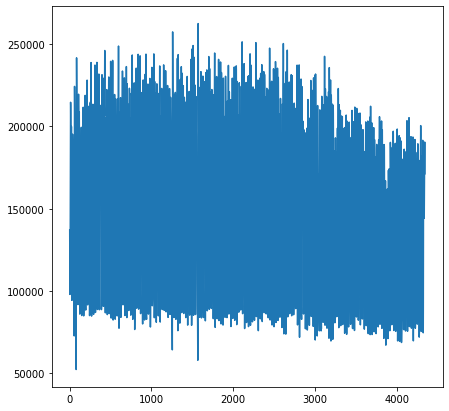

In [182]:
plt.plot(end_prediction[:])
plt.show()

In [178]:
with open("answer2.txt", "w") as f:
    for v in end_prediction[-to_predict:]:
        f.write(str(v))
        f.write('\n')

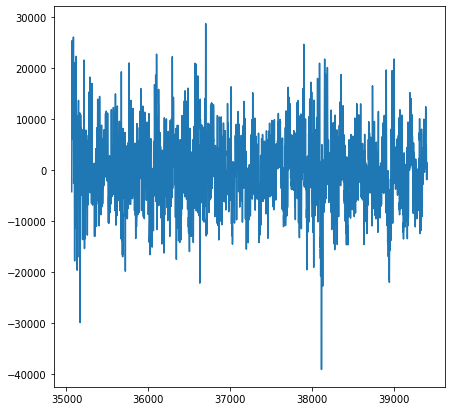

In [156]:
from statsmodels.tsa.ar_model import AutoReg

autoReg = AutoReg(noise, lags = 8760).fit()
answer = autoReg.predict(start=35064, end=35064+4344-1, dynamic=False)
plt.plot(answer)
plt.show()

In [166]:
answer = answer.values
answer

array([-4240.07146516,  3612.83267123,  7880.72438585, ...,
       -1876.96825352,  1489.86774336, -1699.15910548])

In [167]:
X_submit['leftovers'] = answer
X_submit

,year,season,month,week_of_year,is_weekend,weekday,hour,leftovers
0,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.000000,-4240.071465
1,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.043478,3612.832671
2,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.086957,7880.724386
3,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.130435,10230.355186
4,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.173913,18435.591154
...,...,...,...,...,...,...,...,...
4339,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.826087,3834.242019
4340,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.869565,-355.036812
4341,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.913043,-1876.968254
4342,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.956522,1489.867743


In [173]:
with open('leftovers.txt','w') as f:
    for a in answer:
        f.write(str(a))
        f.write('\n')